In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time
from pyod.models.cblof import CBLOF
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import seaborn as sns
sns.set()
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import RobustScaler
from pyod.utils.example import visualize
import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

data load

In [2]:
data = pd.read_csv('Dataset.csv', sep=',')
data.head(10)

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.0,50.0,50.0,0.000000,50.0,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.0,50.0,100.0,50.000000,25.0,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.0,10.0,20.0,10.000000,10.0,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.0,30.0,70.0,40.000000,30.0,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.0,30.0,60.0,30.000000,15.0,0,0,0,0,0
5,298ca2045d174f8a158961806ffc4ef96fad02d71a6b84...,1,0,1.0,0.0,1.0,1.000000,0.0,0,0,0,0,0
6,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,1,2,29.0,29.0,58.0,29.000000,14.5,0,0,0,0,0
7,4385fcf8b14497d0659adccfe06ae7e38e0b5dc95ff8a1...,1,1,1.0,1.0,2.0,1.000000,1.0,0,0,0,0,0
8,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,1,1,28.0,10.0,38.0,28.000000,10.0,0,0,0,0,0
9,a3b0e9e7cddbbe78270fa4182a7675ff00b92872d8df7d...,3,0,61.0,0.0,61.0,20.333333,0.0,0,0,0,0,0


In [3]:
data.drop('tx_hash', axis=1, inplace=True)
data.drop('in_malicious', axis=1, inplace=True)
data.drop('out_malicious', axis=1, inplace=True)
data.drop('is_malicious', axis=1, inplace=True)
data.drop('all_malicious', axis=1, inplace=True)



data.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,2.148699e+00,2.148699e+00,5.484150e+01,5.484150e+01,1.096830e+02,4.923980e+01,2.877087e+01,3.570468e-06
std,7.421447e+00,4.512048e+00,1.303303e+03,1.301473e+03,2.602527e+03,9.729210e+02,7.125567e+02,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e-01,9.950000e-02,2.058720e-01,6.400000e-02,5.025776e-02,0.000000e+00
50%,1.000000e+00,2.000000e+00,9.325000e-01,9.590000e-01,1.964759e+00,5.350261e-01,4.900000e-01,0.000000e+00
75%,2.000000e+00,2.000000e+00,8.591912e+00,9.063657e+00,1.840000e+01,5.614287e+00,4.519481e+00,0.000000e+00
max,1.932000e+03,1.322000e+03,5.500000e+05,5.000207e+05,1.050000e+06,4.992596e+05,5.000000e+05,1.000000e+00


In [4]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(data['out_and_tx_malicious'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['out_and_tx_malicious'].value_counts()[1]/len(data) * 100,5), '% of the dataset')

No Frauds 100.0 % of the dataset
Frauds 0.00036 % of the dataset


In [5]:
data['out_and_tx_malicious'].value_counts()

0    30248026
1         108
Name: out_and_tx_malicious, dtype: int64

SCale transform

In [6]:
# Log scale to normalize the data
sc_data = data.copy()

sc_data['indegree'] = np.log1p(sc_data['indegree'])
sc_data['outdegree']= np.log1p(sc_data['outdegree'])
sc_data['in_btc'] = np.log1p(sc_data['in_btc'])
sc_data['out_btc']= np.log1p(sc_data['out_btc'])
sc_data['total_btc']= np.log1p(sc_data['total_btc'])
sc_data['mean_in_btc']= np.log1p(sc_data['mean_in_btc'])
sc_data['mean_out_btc']= np.log1p(sc_data['mean_out_btc'])

# RobustScaler is less prone to outliers.

scaler = RobustScaler()

sc_data['indegree'] = scaler.fit_transform(sc_data['indegree'].values.reshape(-1,1))
sc_data['outdegree'] = scaler.fit_transform(sc_data['outdegree'].values.reshape(-1,1))
sc_data['in_btc'] = scaler.fit_transform(sc_data['in_btc'].values.reshape(-1,1))
sc_data['out_btc'] = scaler.fit_transform(sc_data['out_btc'].values.reshape(-1,1))
sc_data['total_btc'] = scaler.fit_transform(sc_data['total_btc'].values.reshape(-1,1))
sc_data['mean_in_btc'] = scaler.fit_transform(sc_data['mean_in_btc'].values.reshape(-1,1))
sc_data['mean_out_btc'] = scaler.fit_transform(sc_data['mean_out_btc'].values.reshape(-1,1))

In [7]:
sc_data.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,6.132702e-01,-2.626722e-02,3.117960e-01,3.069471e-01,2.302426e-01,4.080517e-01,3.952796e-01,3.570468e-06
std,1.137854e+00,2.681126e-01,7.289874e-01,7.166882e-01,6.480901e-01,8.308393e-01,8.356174e-01,1.889565e-03
min,-1.709511e+00,-1.098612e+00,-3.042166e-01,-3.037088e-01,-3.912052e-01,-2.345382e-01,-2.403354e-01,0.000000e+00
25%,0.000000e+00,0.000000e+00,-2.602058e-01,-2.608668e-01,-3.238193e-01,-2.005871e-01,-2.107825e-01,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,7.397942e-01,7.391332e-01,6.761807e-01,7.994129e-01,7.892175e-01,0.000000e+00
max,1.695258e+01,6.089045e+00,5.799225e+00,5.623103e+00,4.599418e+00,6.946344e+00,7.668286e+00,1.000000e+00


In [11]:
del data
gc.collect()

0

Split

In [8]:
train_x, test_x, train_y, test_y = train_test_split(sc_data.iloc[:,:-1], sc_data['out_and_tx_malicious'], test_size = 0.30, random_state=42)

In [9]:
pd.value_counts(train_y)

0    21173628
1          65
Name: out_and_tx_malicious, dtype: int64

In [10]:
pd.value_counts(test_y)

0    9074398
1         43
Name: out_and_tx_malicious, dtype: int64

In [15]:
del sc_data #free memory
gc.collect()

0

Training samples

In [11]:


data_train = pd.concat([train_x, train_y], axis=1)
nonfraud_train = data_train[data_train.out_and_tx_malicious == 0]
fraud_train = data_train[data_train.out_and_tx_malicious == 1]

def get_training_sample(n):
    non_fraud = nonfraud_train.sample(n)
    trained_data = pd.concat([non_fraud, fraud_train])
    trained_data = shuffle(trained_data)

    return trained_data.iloc[:,:-1].values, trained_data.iloc[:,-1].values

Test Samples

In [12]:
data_test = pd.concat([test_x, test_y], axis=1)
nonfraud_test = data_test[data_test.out_and_tx_malicious == 0]
fraud_test = data_test[data_test.out_and_tx_malicious == 1]

def get_test_sample(n):
    non_fraud = nonfraud_test.sample(n)
    tested_data = pd.concat([non_fraud, fraud_test])
    tested_data = shuffle(tested_data)
    return tested_data.iloc[:,:-1].values, tested_data.iloc[:,-1].values

oversample train data

In [13]:


def oversample_minority_class(X, y, fraction):
    SM = SMOTE(fraction, n_jobs=-1)
    return SM.fit_resample(X, y)

Eval Metrics

In [14]:
def met_eval(actual, predicted, probability, time_complexity):
    meteval = {}
    meteval['time'] = time_complexity
    meteval['conf_matrix'] = confusion_matrix(actual, predicted)

    meteval['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    meteval['accuracy'] = round(accuracy_score(actual, predicted),7)

    meteval['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    meteval['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    meteval['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    meteval['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)


    meteval['precision'] = round(precision_score(actual, predicted),7)
    meteval['recall'] = round(recall_score(actual,predicted),7)
    meteval['f1'] = round(f1_score(actual,predicted),7)
    meteval['roc'] = round(roc_auc_score(actual, probability),7)

    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    meteval['false_pos_rate'] = false_pos_rate
    meteval['true_pos_rate'] = true_pos_rate
    meteval['thresholds'] = thresholds

    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    meteval['precision_rt'] = precision_rt
    meteval['recall_rt'] = recall_rt
    meteval['threshold_rt'] = threshold_rt
    return meteval


Model fit

In [20]:


iters = 15
rand_state = 42
train_ssize = int(len(train_y) / 10)
sampl_frac = 0.057
out_frac = sampl_frac

print('Training Parameters:\n====================\n')
print('Iterations: '+ str(iters))
print('Training Sample Size: '+ str(train_ssize))
print('Oversampling Fraction: '+ str(sampl_frac))
print('Outliers Fraction: '+ str(out_frac))

#best: {'alpha': 0.8394485188873344, 'beta': 2.090218289939831, 'n_clusters': 7.899400867394069, 'outliers_fraction': 0.23561901292786977}

def fit_model(train):
    clf = CBLOF(n_clusters=10, contamination=out_frac, clustering_estimator=None, alpha=0.75, beta=5, use_weights=True, check_estimator=False, random_state=rand_state, n_jobs=-1)
    clf.fit(train)
    return clf

Training Parameters:

Iterations: 15
Training Sample Size: 2117369
Oversampling Fraction: 0.057
Outliers Fraction: 0.057


Iterative modeling

In [21]:
eval_train = {}
eval_test = {}
mod = {}


for i in range(0, iters):
    train_samplex, train_sampley = get_training_sample(train_ssize)
    train, y_train = oversample_minority_class(train_samplex, train_sampley, sampl_frac)
    print("Iteration "+ str(i+1) + " in progress...")

    #Modeling
    start = time.time()
    clf = fit_model(train)
    end = time.time()
    # get the prediction labels and outlier scores of the training data
    pred_trainy = clf.labels_  # binary labels (0: inliers, 1: outliers)
    score_trainy = clf.decision_scores_  # raw outlier scores

    train_time = round(end - start, 4)
    mod[i+1] = clf
    eval_train[i+1] = met_eval(y_train, pred_trainy, score_trainy, train_time)

    print("Iteration "+ str(i+1)+ " Trained")

    test_start = time.time()
    pred_testy = clf.predict(test_x)
    score_testy = clf.decision_function(test_x)
    end_test = time.time()
    time_test = round(end_test - test_start, 4)
    eval_test[i+1] = met_eval(test_y, pred_testy, score_testy, time_test)

    print("Iteration: (" + str((i+1)) + "/" + str(iters) + ")    Training Time: "+str(train_time)+" seconds     Testing Time: "+ str(time_test)+ " seconds")

print("Iterative Modeling Completed!")

Iteration 1 in progress...
Iteration 1 Trained
Iteration: (1/15)    Training Time: 45.4604 seconds     Testing Time: 3.7304 seconds
Iteration 2 in progress...
Iteration 2 Trained
Iteration: (2/15)    Training Time: 44.449 seconds     Testing Time: 6.0231 seconds
Iteration 3 in progress...
Iteration 3 Trained
Iteration: (3/15)    Training Time: 43.4497 seconds     Testing Time: 3.8637 seconds
Iteration 4 in progress...
Iteration 4 Trained
Iteration: (4/15)    Training Time: 42.1069 seconds     Testing Time: 5.3769 seconds
Iteration 5 in progress...
Iteration 5 Trained
Iteration: (5/15)    Training Time: 44.4206 seconds     Testing Time: 5.2146 seconds
Iteration 6 in progress...
Iteration 6 Trained
Iteration: (6/15)    Training Time: 42.0083 seconds     Testing Time: 4.5787 seconds
Iteration 7 in progress...
Iteration 7 Trained
Iteration: (7/15)    Training Time: 43.5576 seconds     Testing Time: 5.7011 seconds
Iteration 8 in progress...
Iteration 8 Trained
Iteration: (8/15)    Training 

Tabular Eval

In [22]:
eval_train_data = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
eval_test_data = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(eval_train.keys()):
    eval_train_data = eval_train_data.append({'Iteration' : str(it),
                                                'Accuracy' : eval_train[it]['accuracy'],
                                                'Balanced-Accuracy' : eval_train[it]['balanced_accuracy'],
                                                'Macro-Precision' : eval_train[it]['macro_precision'],
                                                'Macro-Recall' : eval_train[it]['macro_recall'],
                                                'Macro-F1' : eval_train[it]['macro_f1'],
                                                'Macro-ROC' : eval_train[it]['macro_roc'],
                                                'Precision' : eval_train[it]['precision'],
                                                'Recall' : eval_train[it]['recall'],
                                                'F1' : eval_train[it]['f1'],
                                                'ROC' : eval_train[it]['roc'],
                                                'Time' : eval_train[it]['time']
                                                }, ignore_index=True)

for it in list(eval_test.keys()):
    eval_test_data = eval_test_data.append({'Iteration' : str(it),
                                        'Accuracy' : eval_test[it]['accuracy'],
                                        'Balanced-Accuracy' : eval_test[it]['balanced_accuracy'],
                                        'Macro-Precision' : eval_test[it]['macro_precision'],
                                        'Macro-Recall' : eval_test[it]['macro_recall'],
                                        'Macro-F1' : eval_test[it]['macro_f1'],
                                        'Macro-ROC' : eval_test[it]['macro_roc'],
                                        'Precision' : eval_test[it]['precision'],
                                        'Recall' : eval_test[it]['recall'],
                                        'F1' : eval_test[it]['f1'],
                                        'ROC' : eval_test[it]['roc'],
                                        'Time' : eval_test[it]['time']
                                        }, ignore_index=True)
    

In [23]:
eval_train_data.sort_values('Macro-F1', ascending=True)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,1,0.889708,0.472984,0.474358,0.472984,0.473668,0.518031,0.005566,0.005883,0.005720,0.518031,45.4604
1,2,0.889740,0.473142,0.474508,0.473142,0.473821,0.391070,0.005848,0.006181,0.006010,0.391070,44.4490
5,6,0.889743,0.473155,0.474520,0.473155,0.473834,0.526552,0.005871,0.006206,0.006034,0.526552,42.0083
10,11,0.889766,0.473269,0.474628,0.473269,0.473945,0.520714,0.006075,0.006421,0.006243,0.520714,47.0981
12,13,0.889825,0.473558,0.474903,0.473558,0.474226,0.563318,0.006593,0.006968,0.006775,0.563318,43.8823
7,8,0.889827,0.473567,0.474911,0.473567,0.474235,0.561400,0.006608,0.006985,0.006791,0.561400,42.5703
9,10,0.889830,0.473580,0.474923,0.473580,0.474248,0.403479,0.006632,0.007010,0.006815,0.403479,42.4130
13,14,0.889843,0.473646,0.474986,0.473646,0.474312,0.402327,0.006749,0.007134,0.006936,0.402327,41.3155
14,15,0.889855,0.473703,0.475040,0.473703,0.474367,0.402359,0.006851,0.007242,0.007041,0.402359,45.9001
6,7,0.889881,0.473830,0.475160,0.473830,0.474491,0.401136,0.007078,0.007482,0.007275,0.401136,43.5576


In [24]:
eval_train_data.sort_values('ROC', ascending=True)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
1,2,0.889740,0.473142,0.474508,0.473142,0.473821,0.391070,0.005848,0.006181,0.006010,0.391070,44.4490
6,7,0.889881,0.473830,0.475160,0.473830,0.474491,0.401136,0.007078,0.007482,0.007275,0.401136,43.5576
13,14,0.889843,0.473646,0.474986,0.473646,0.474312,0.402327,0.006749,0.007134,0.006936,0.402327,41.3155
14,15,0.889855,0.473703,0.475040,0.473703,0.474367,0.402359,0.006851,0.007242,0.007041,0.402359,45.9001
9,10,0.889830,0.473580,0.474923,0.473580,0.474248,0.403479,0.006632,0.007010,0.006815,0.403479,42.4130
11,12,0.889956,0.474197,0.475509,0.474197,0.474849,0.411644,0.007737,0.008178,0.007951,0.411644,46.0851
8,9,0.889898,0.473917,0.475243,0.473917,0.474576,0.413616,0.007235,0.007648,0.007436,0.413616,40.7969
4,5,0.889933,0.474076,0.475393,0.474076,0.474730,0.416063,0.007518,0.007946,0.007726,0.416063,44.4206
2,3,0.890826,0.478458,0.479554,0.478458,0.478999,0.443234,0.015364,0.016240,0.015790,0.443234,43.4497
0,1,0.889708,0.472984,0.474358,0.472984,0.473668,0.518031,0.005566,0.005883,0.005720,0.518031,45.4604


In [25]:
eval_test_data.sort_values('Macro-F1', ascending=True)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
6,7,0.939794,0.469900,0.499997,0.469900,0.484482,0.448985,0.0,0.0,0.0,0.448985,5.7011
11,12,0.939865,0.469935,0.499997,0.469935,0.484500,0.453293,0.0,0.0,0.0,0.453293,4.8848
5,6,0.939870,0.469937,0.499997,0.469937,0.484501,0.520687,0.0,0.0,0.0,0.520687,4.5787
0,1,0.940028,0.470016,0.499997,0.470016,0.484544,0.512085,0.0,0.0,0.0,0.512085,3.7304
1,2,0.940047,0.470026,0.499997,0.470026,0.484548,0.441119,0.0,0.0,0.0,0.441119,6.0231
10,11,0.940083,0.470044,0.499997,0.470044,0.484558,0.515454,0.0,0.0,0.0,0.515454,4.9560
14,15,0.940088,0.470046,0.499997,0.470046,0.484560,0.450599,0.0,0.0,0.0,0.450599,5.4718
12,13,0.940143,0.470074,0.499997,0.470074,0.484574,0.507338,0.0,0.0,0.0,0.507338,6.3365
8,9,0.940198,0.470101,0.499997,0.470101,0.484589,0.454305,0.0,0.0,0.0,0.454305,5.6423
3,4,0.940222,0.470113,0.499997,0.470113,0.484595,0.518955,0.0,0.0,0.0,0.518955,5.3769


In [26]:
eval_test_data.sort_values('ROC', ascending=True)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
1,2,0.940047,0.470026,0.499997,0.470026,0.484548,0.441119,0.0,0.0,0.0,0.441119,6.0231
6,7,0.939794,0.469900,0.499997,0.469900,0.484482,0.448985,0.0,0.0,0.0,0.448985,5.7011
14,15,0.940088,0.470046,0.499997,0.470046,0.484560,0.450599,0.0,0.0,0.0,0.450599,5.4718
9,10,0.940272,0.470138,0.499997,0.470138,0.484608,0.450719,0.0,0.0,0.0,0.450719,5.2525
13,14,0.940239,0.470122,0.499997,0.470122,0.484600,0.451896,0.0,0.0,0.0,0.451896,5.6101
11,12,0.939865,0.469935,0.499997,0.469935,0.484500,0.453293,0.0,0.0,0.0,0.453293,4.8848
8,9,0.940198,0.470101,0.499997,0.470101,0.484589,0.454305,0.0,0.0,0.0,0.454305,5.6423
4,5,0.940332,0.470168,0.499997,0.470168,0.484624,0.454657,0.0,0.0,0.0,0.454657,5.2146
2,3,0.940479,0.470242,0.499997,0.470242,0.484663,0.455838,0.0,0.0,0.0,0.455838,3.8637
7,8,0.940302,0.470153,0.499997,0.470153,0.484616,0.506320,0.0,0.0,0.0,0.506320,6.0716


Visual metrics

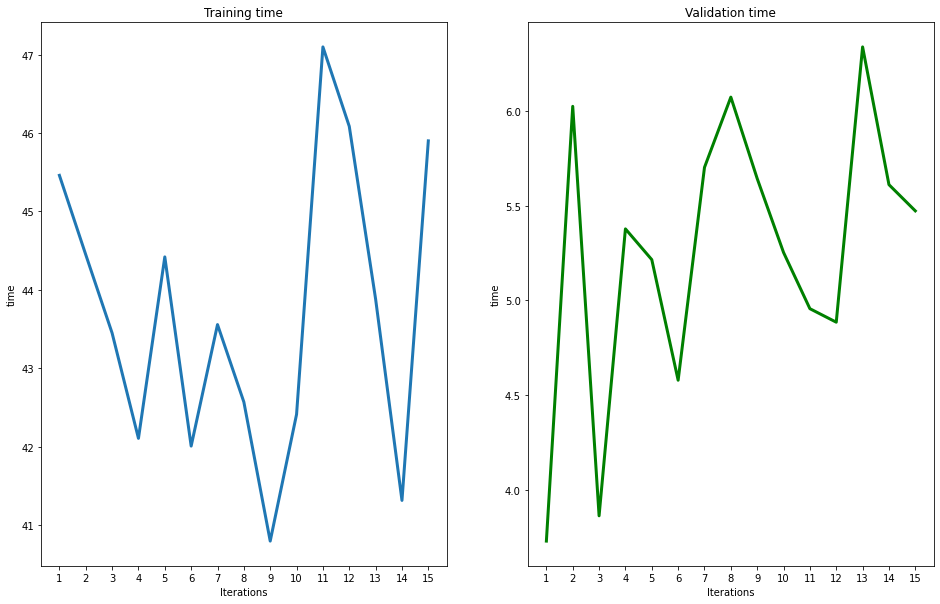

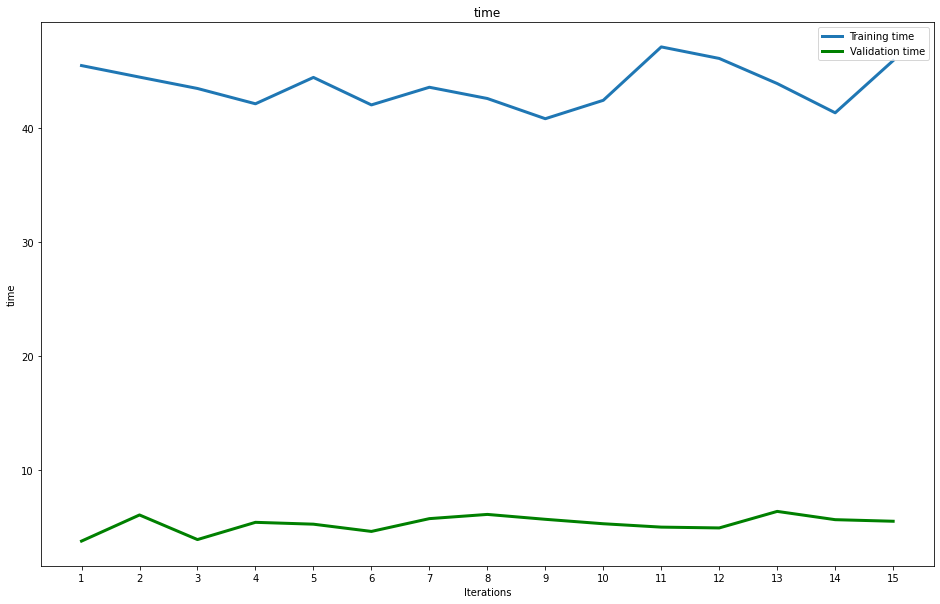

In [27]:
metrics = ['time']
for metric in metrics:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    plt.figure(figsize=(16, 10))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

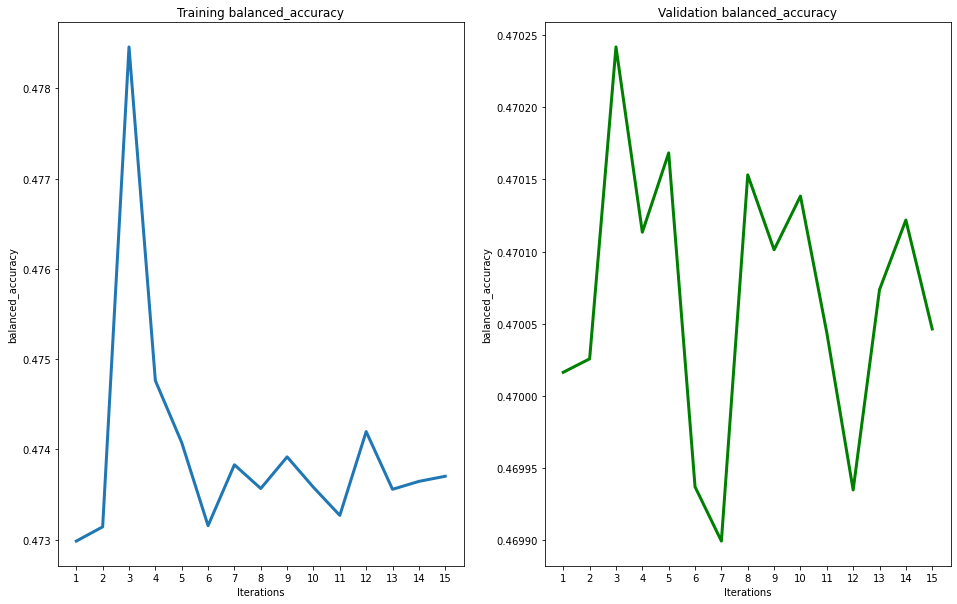

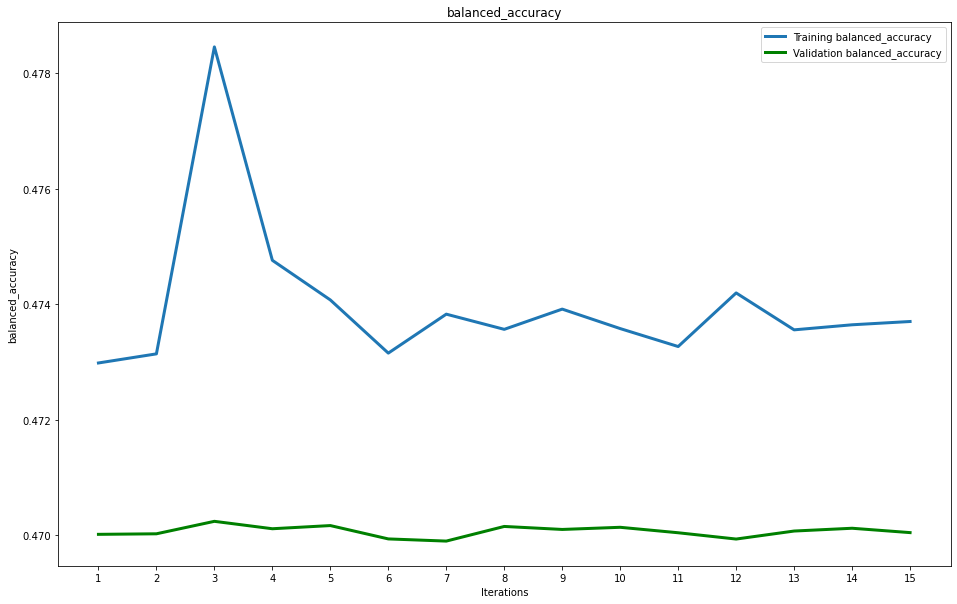

In [28]:
metrics = [ 'balanced_accuracy']
for metric in metrics:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    plt.figure(figsize=(16, 10))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

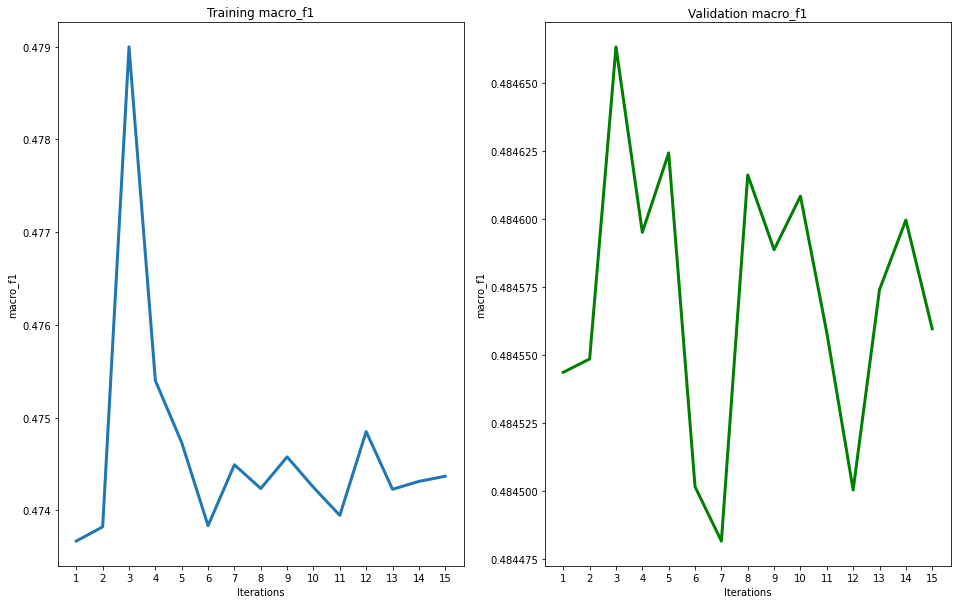

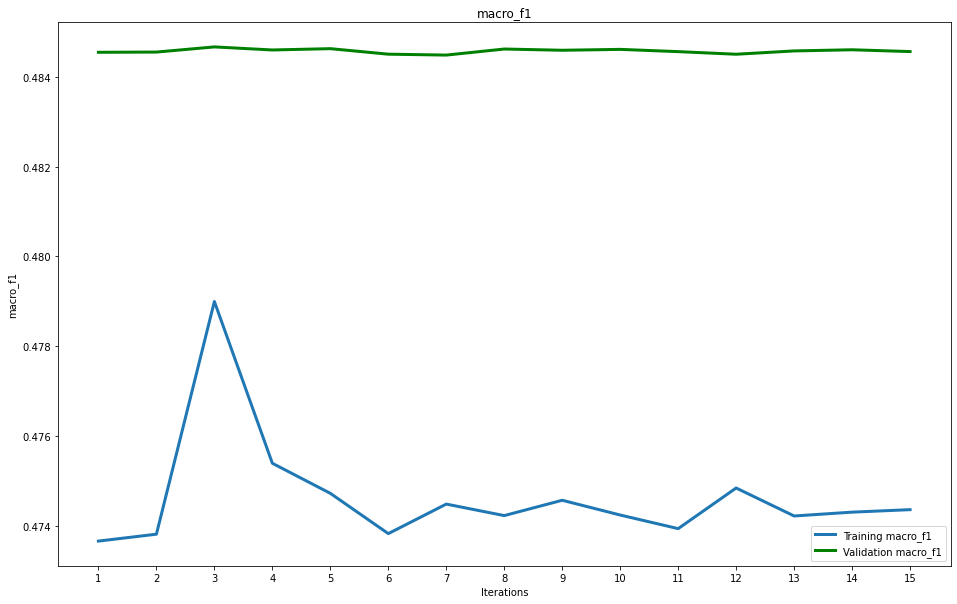

In [29]:
metrics = ['macro_f1']
for metric in metrics:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    plt.figure(figsize=(16, 10))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

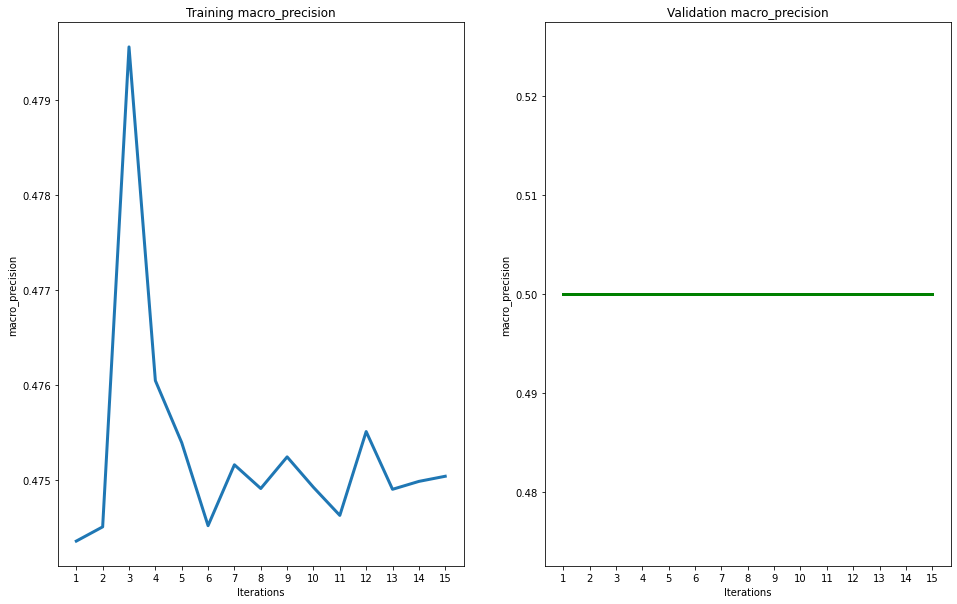

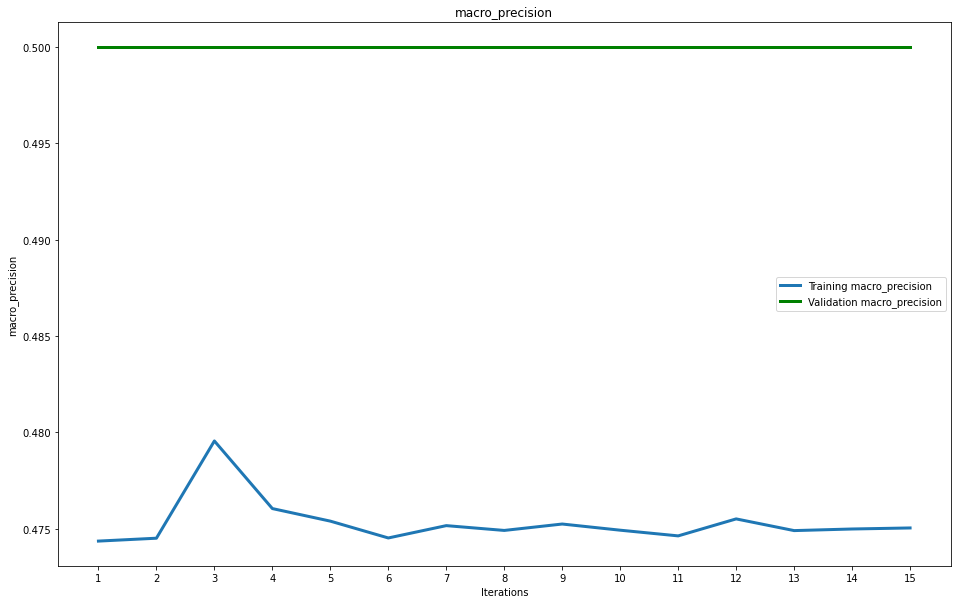

In [30]:
metrics = [ 'macro_precision']
for metric in metrics:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    plt.figure(figsize=(16, 10))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

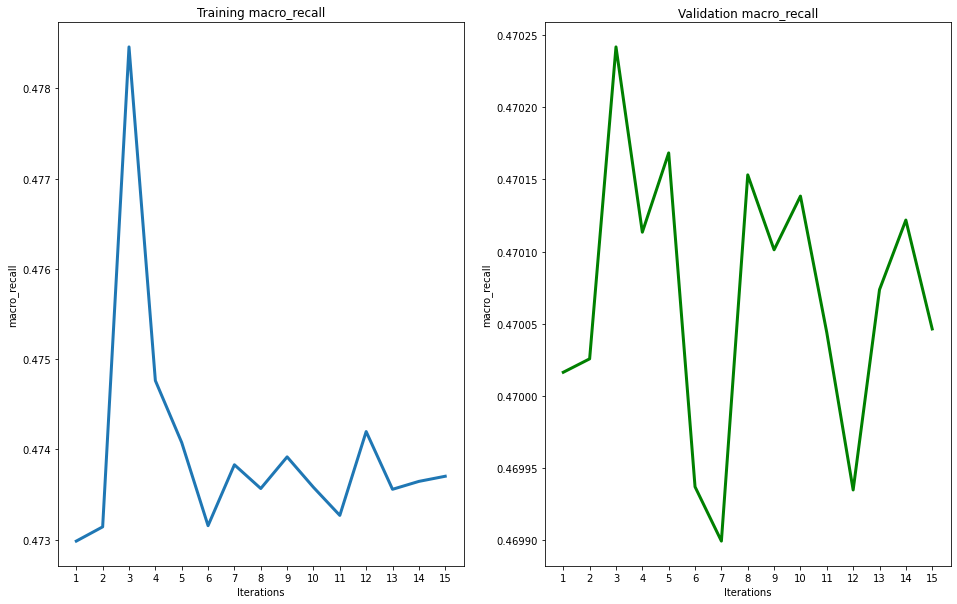

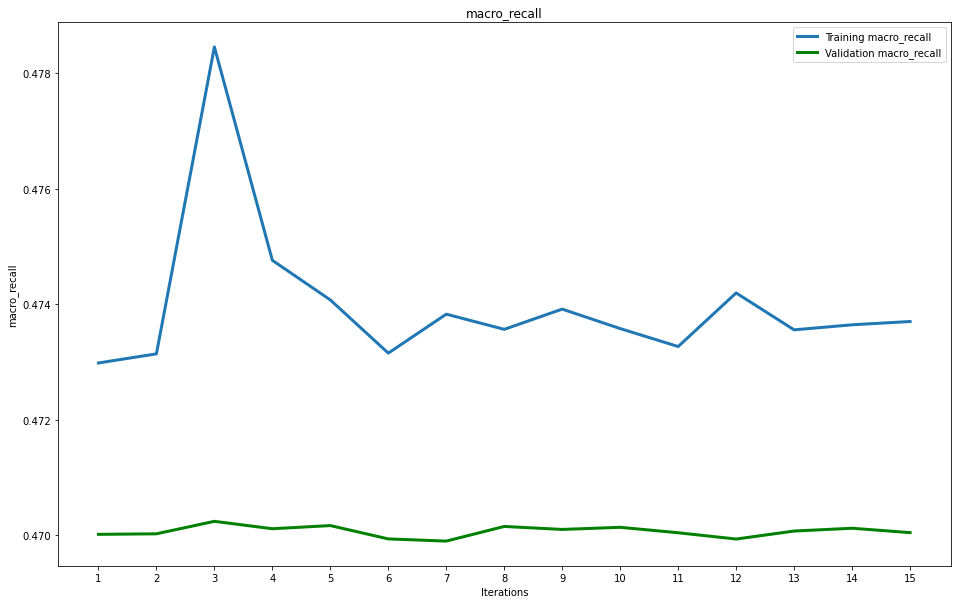

In [31]:
metrics = ['macro_recall']
for metric in metrics:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    plt.figure(figsize=(16, 10))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

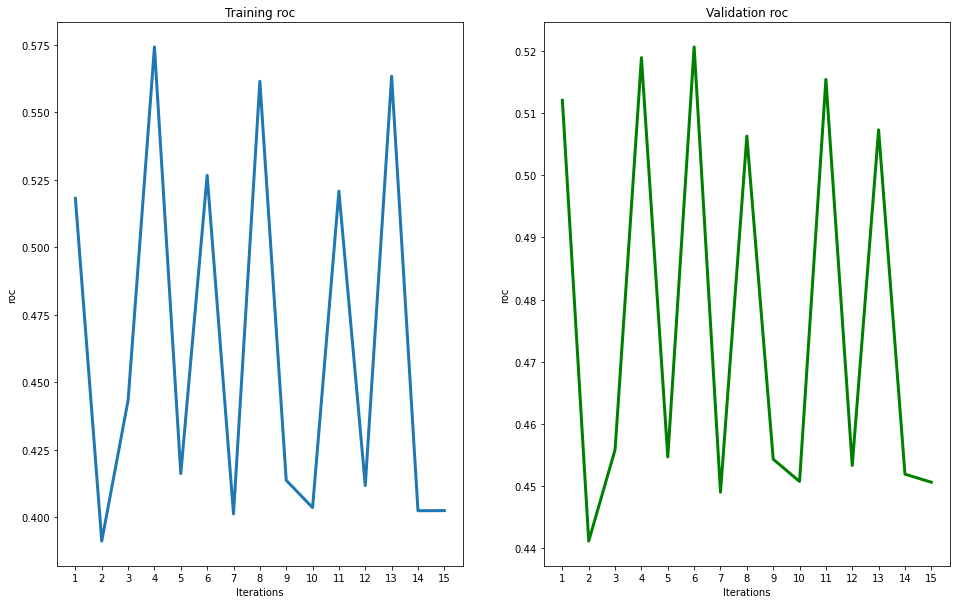

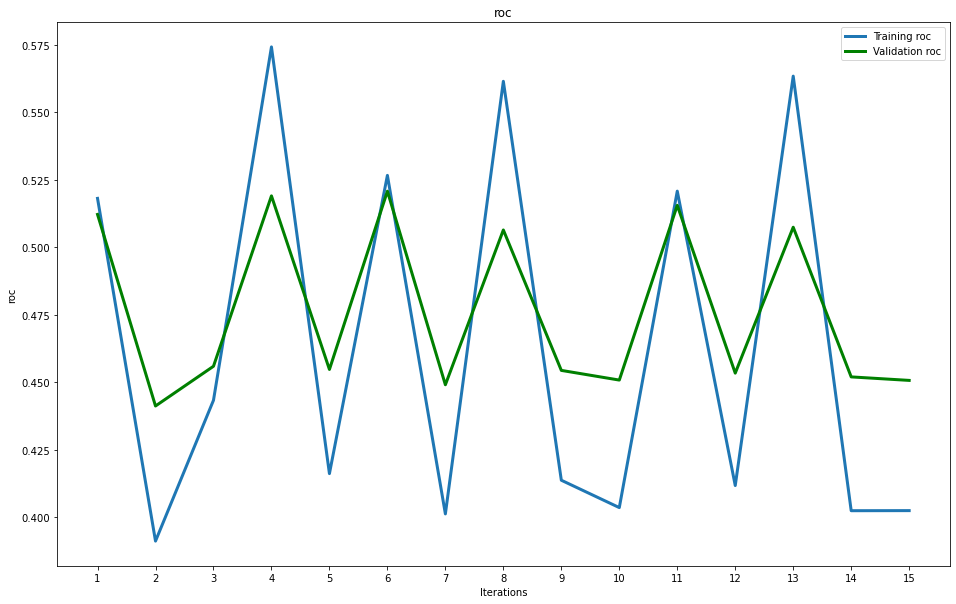

In [32]:
metrics = [ 'roc']
for metric in metrics:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(eval_train.keys())
    result1 = [eval_train[i][metric] for i in list(eval_train.keys())]
    result2 = [eval_test[i][metric] for i in list(eval_test.keys())]
    plt.figure(figsize=(16, 10))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

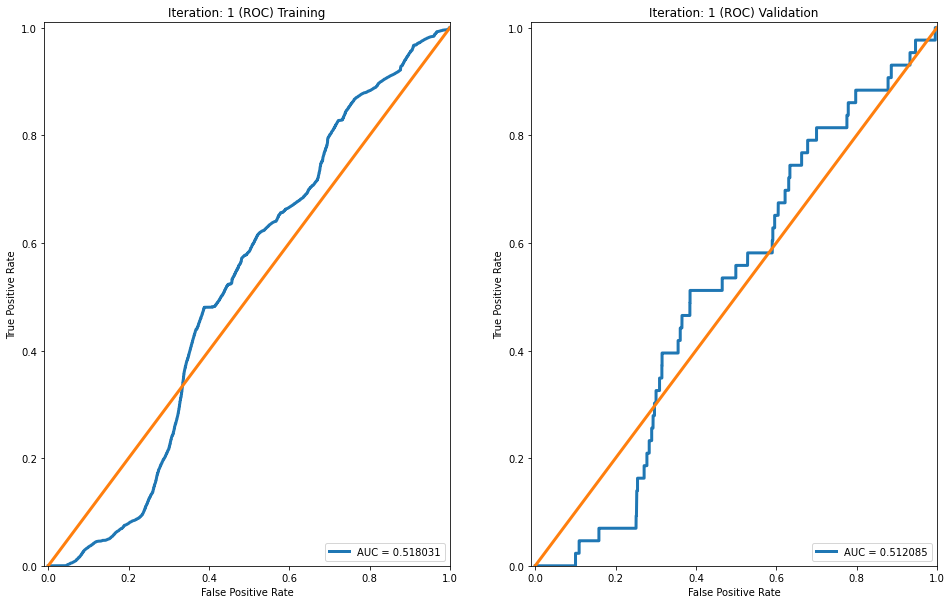

<Figure size 432x288 with 0 Axes>

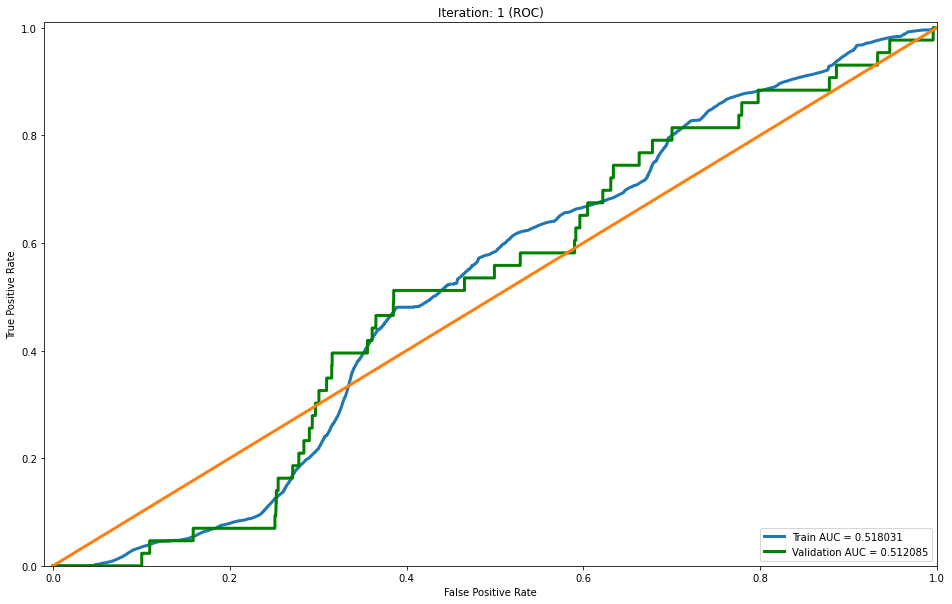

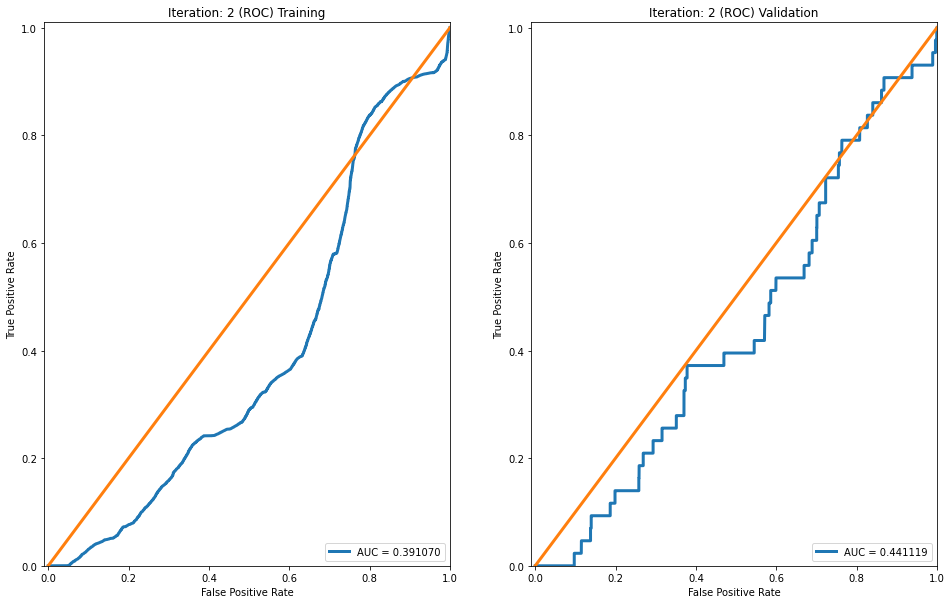

<Figure size 432x288 with 0 Axes>

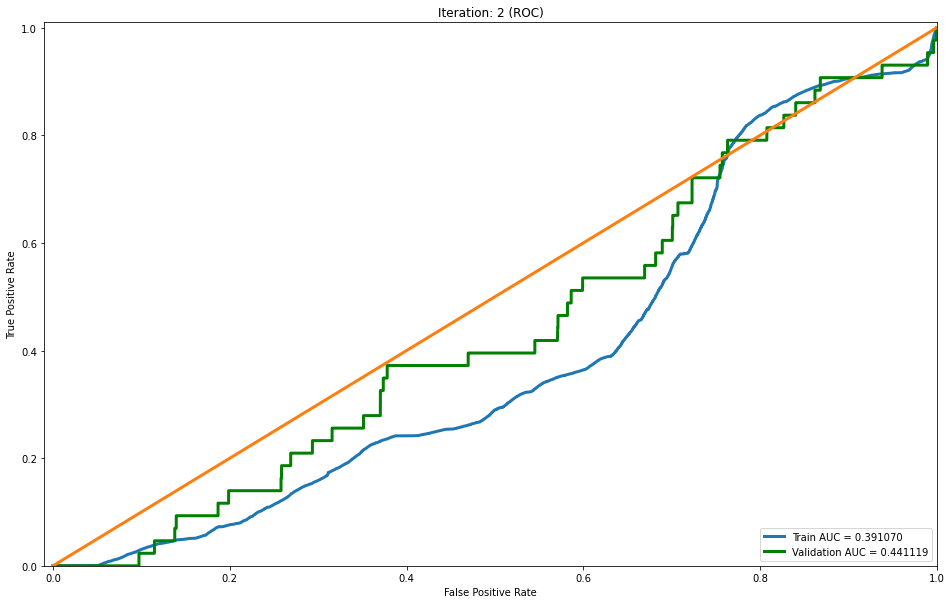

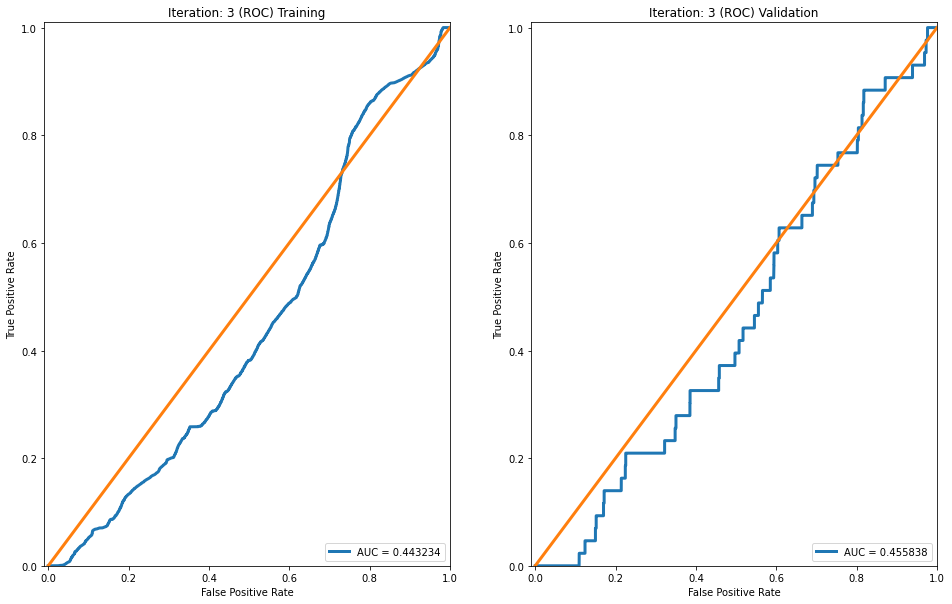

<Figure size 432x288 with 0 Axes>

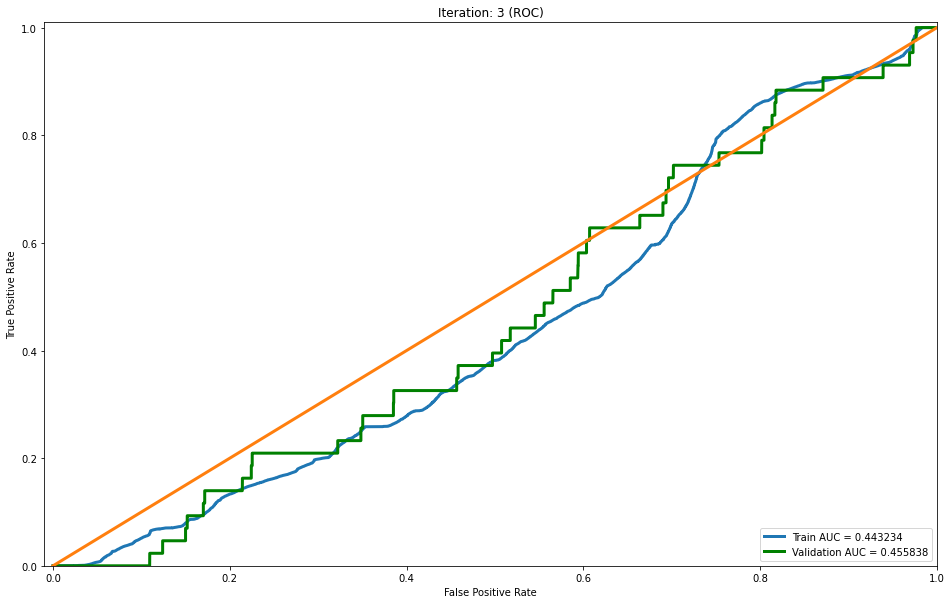

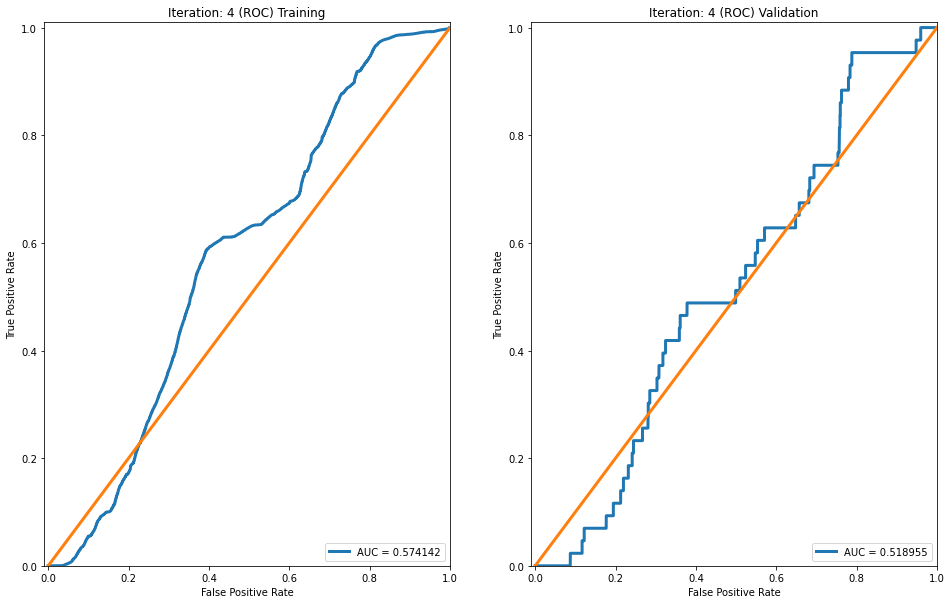

<Figure size 432x288 with 0 Axes>

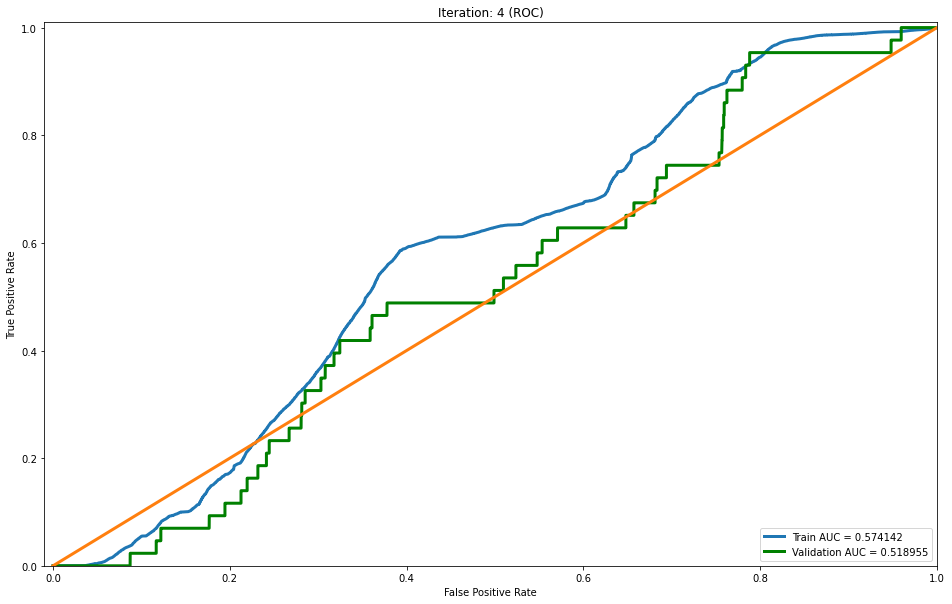

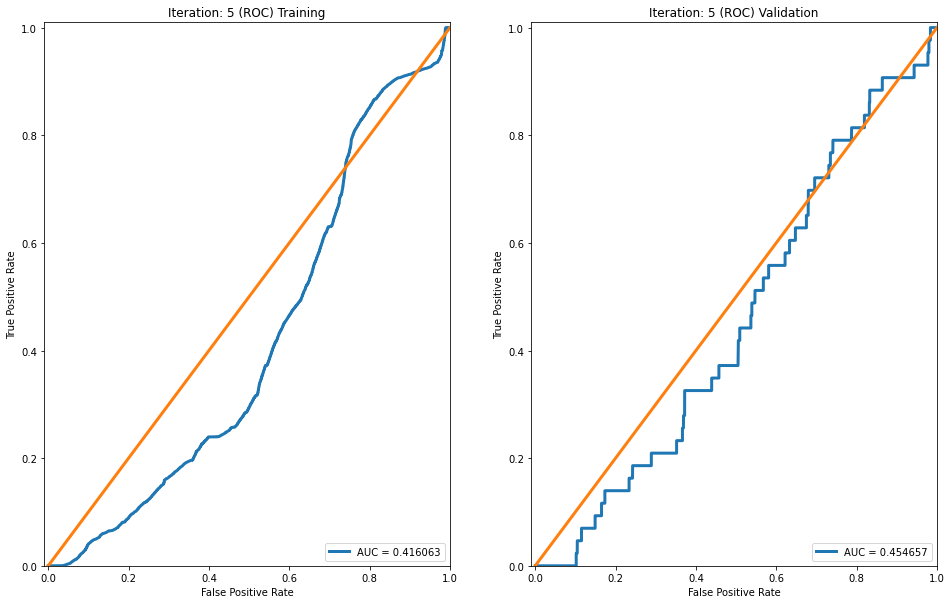

<Figure size 432x288 with 0 Axes>

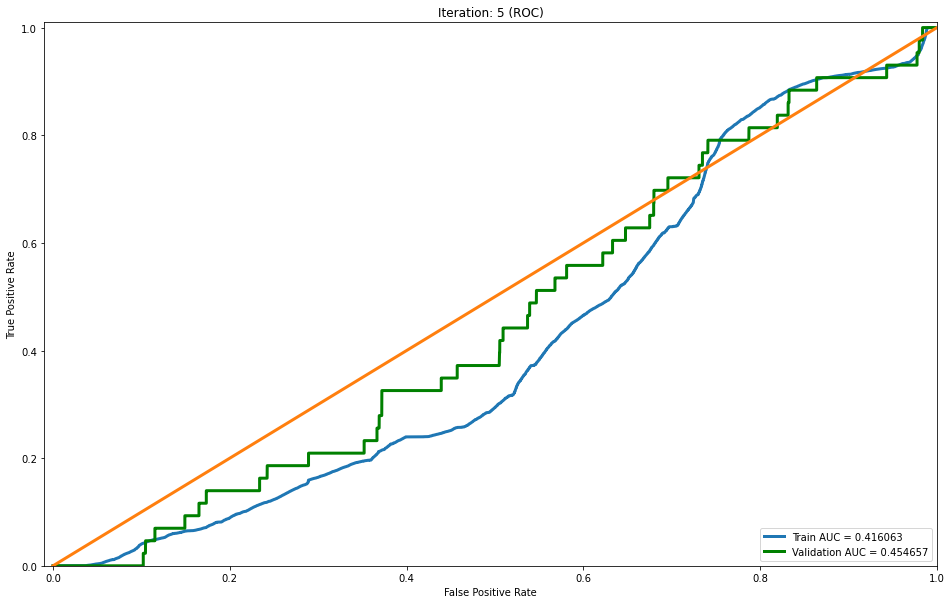

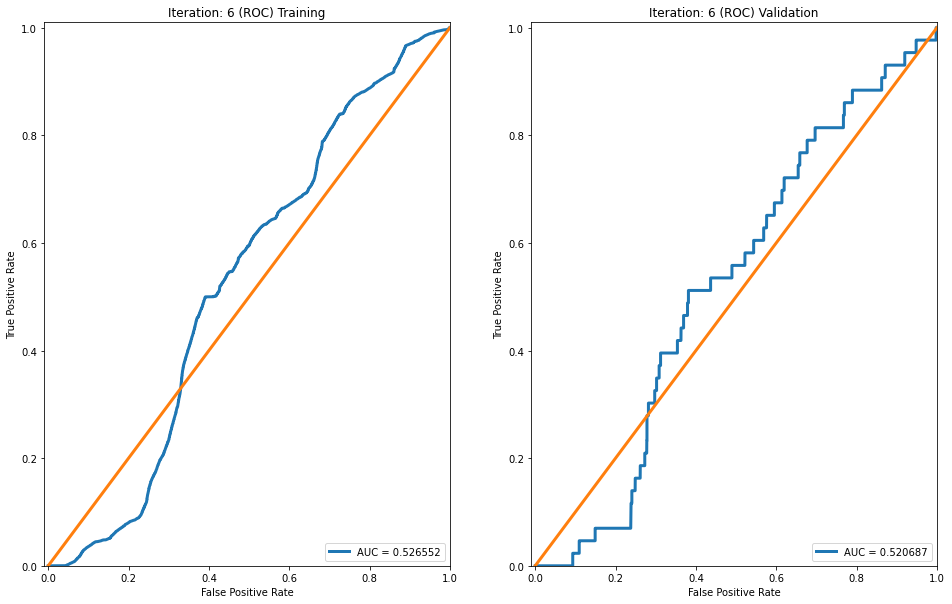

<Figure size 432x288 with 0 Axes>

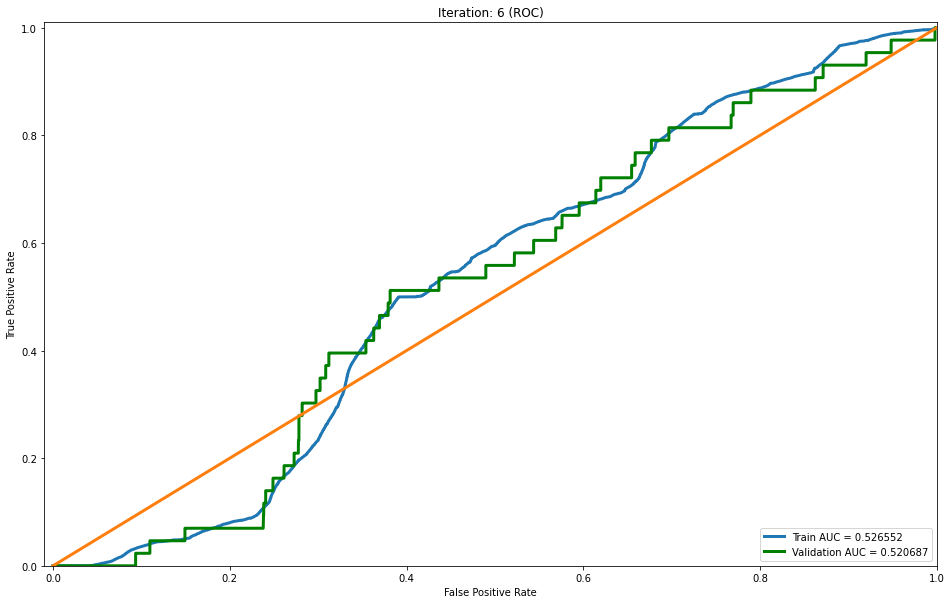

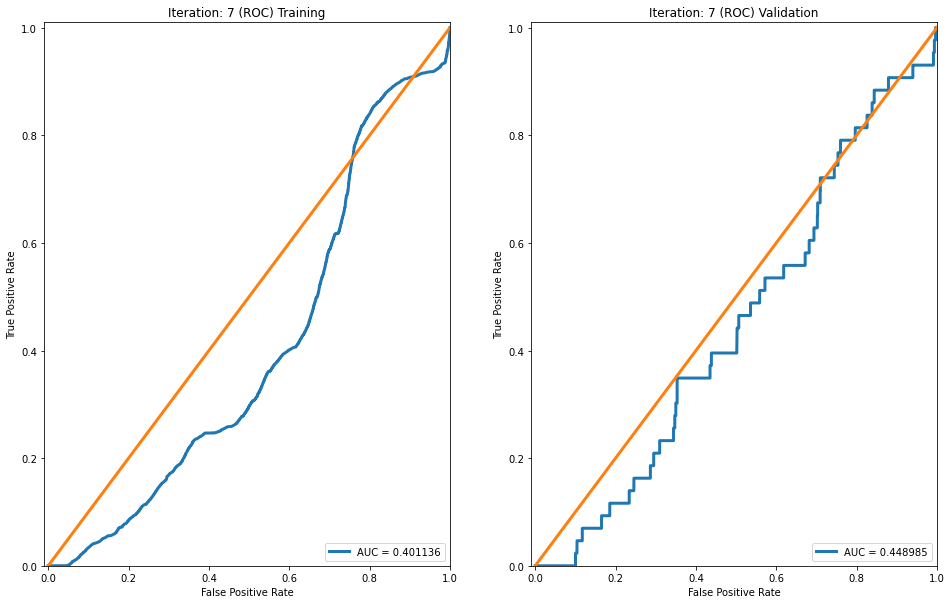

<Figure size 432x288 with 0 Axes>

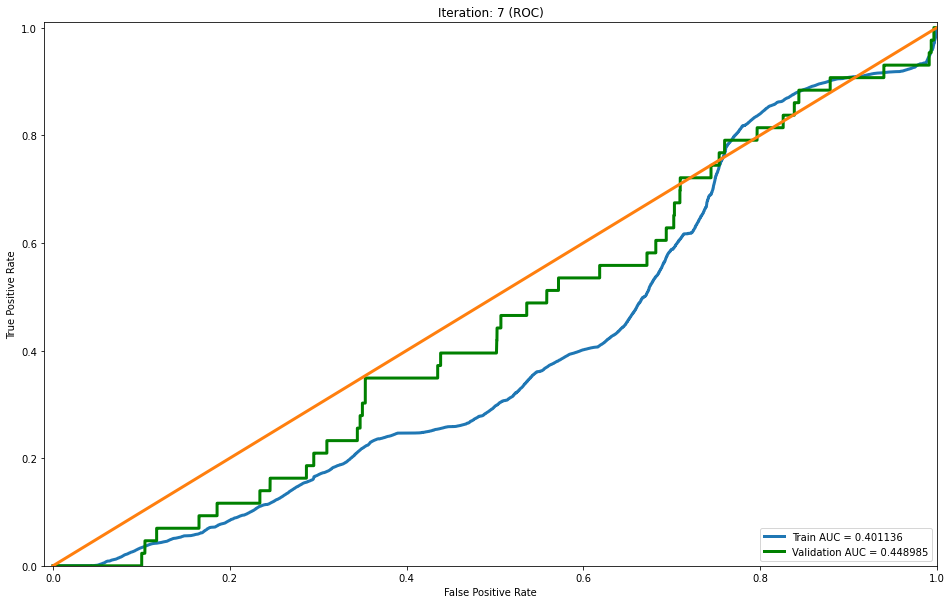

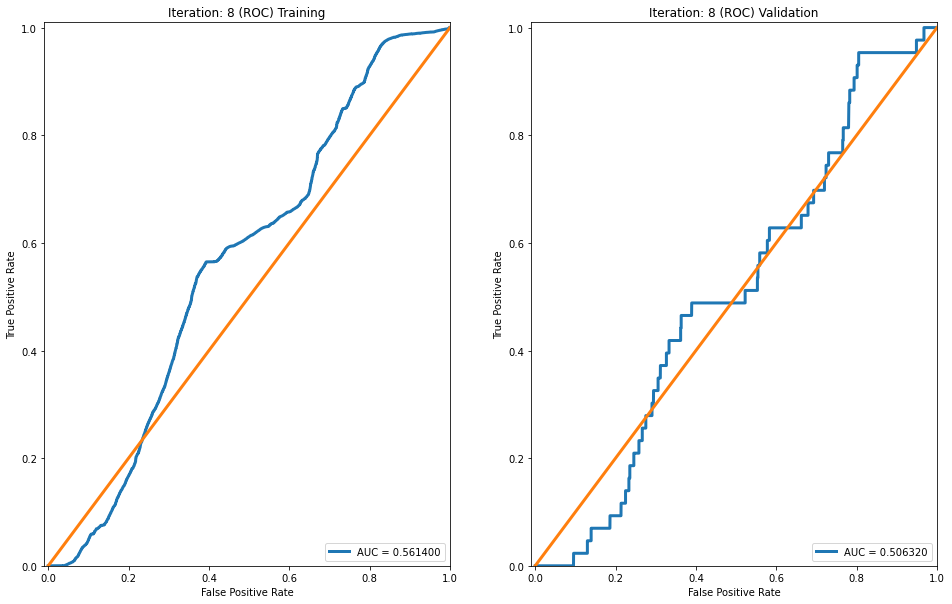

<Figure size 432x288 with 0 Axes>

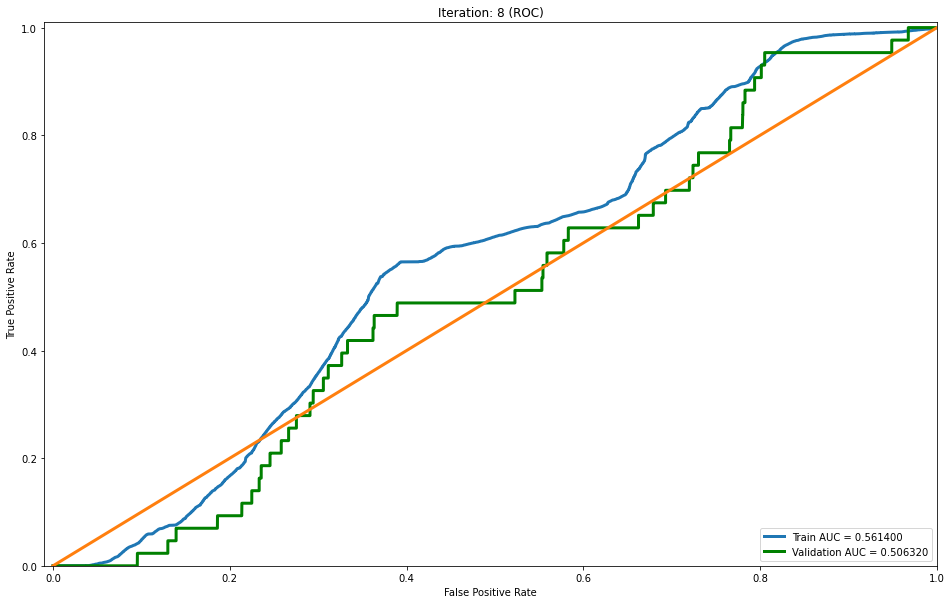

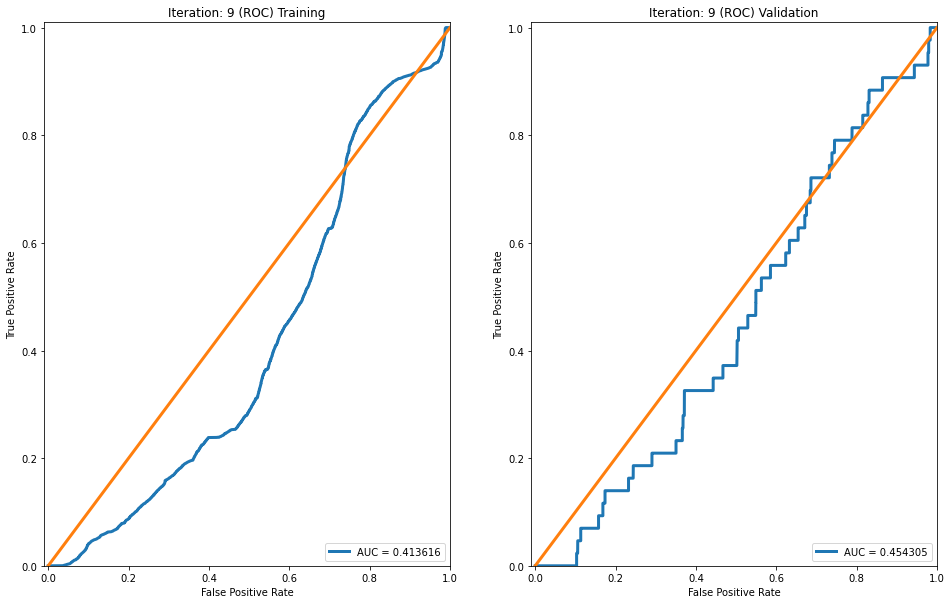

<Figure size 432x288 with 0 Axes>

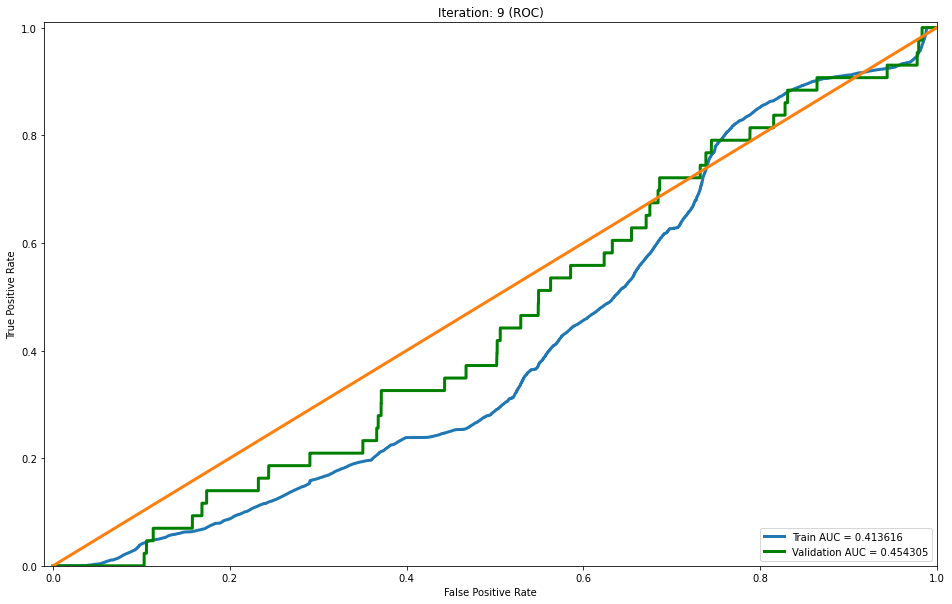

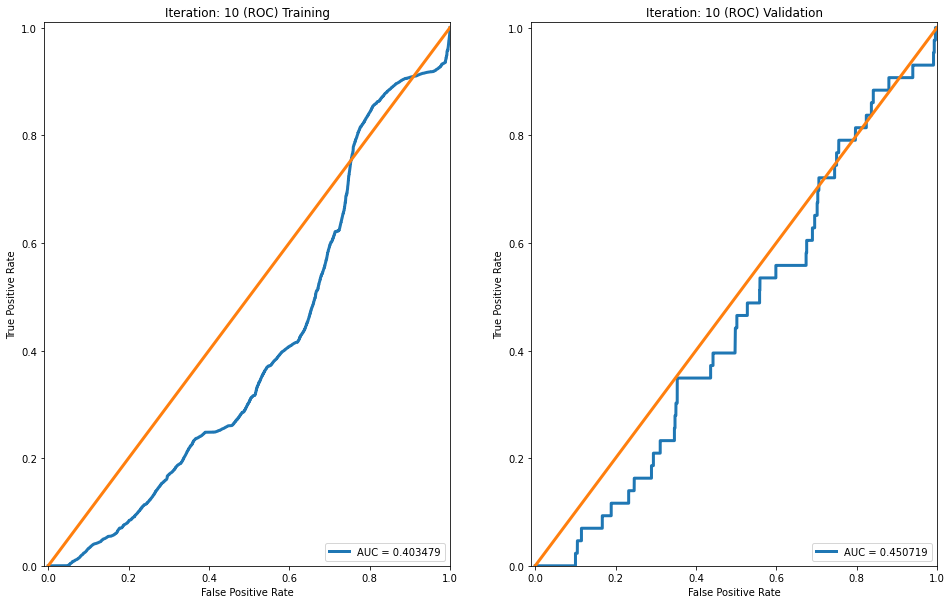

<Figure size 432x288 with 0 Axes>

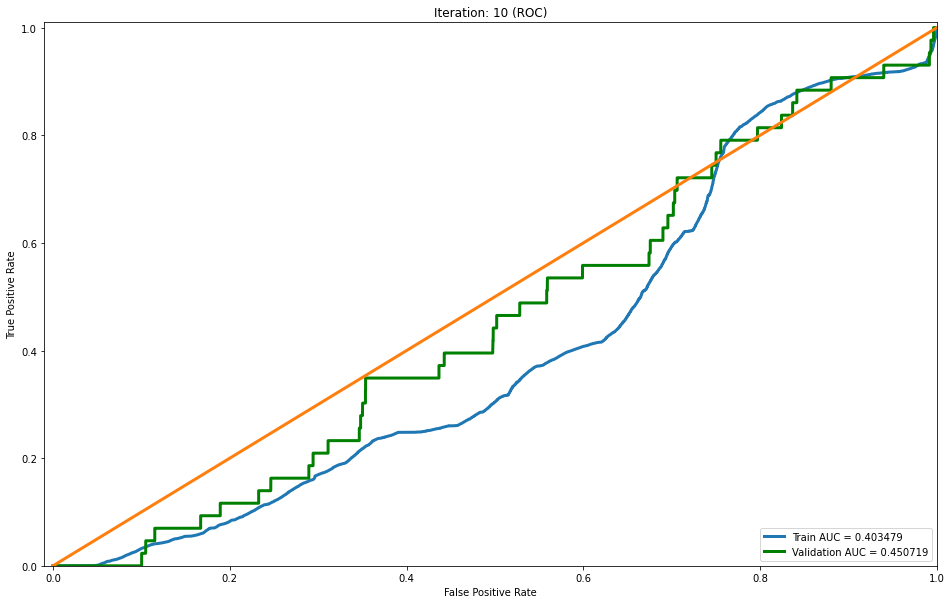

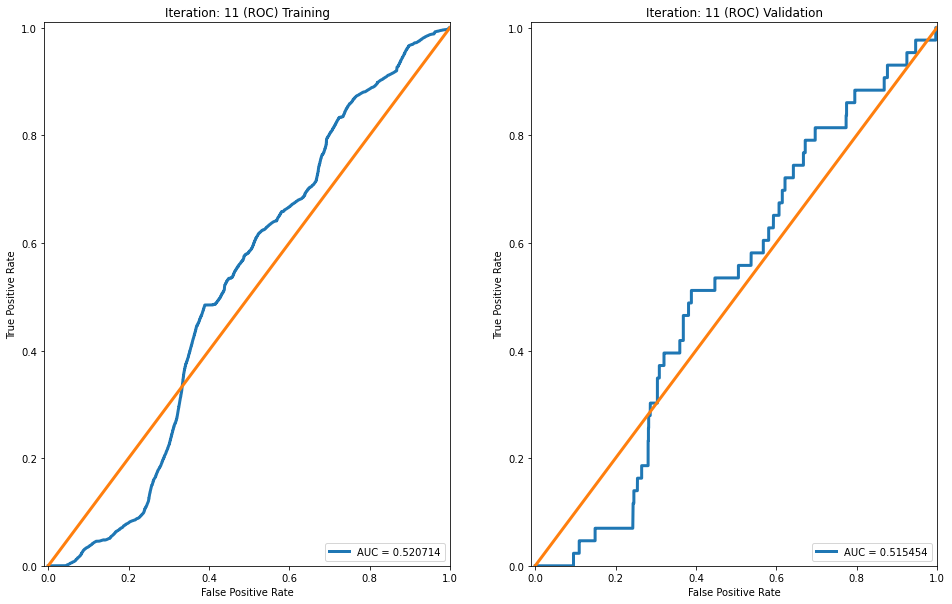

<Figure size 432x288 with 0 Axes>

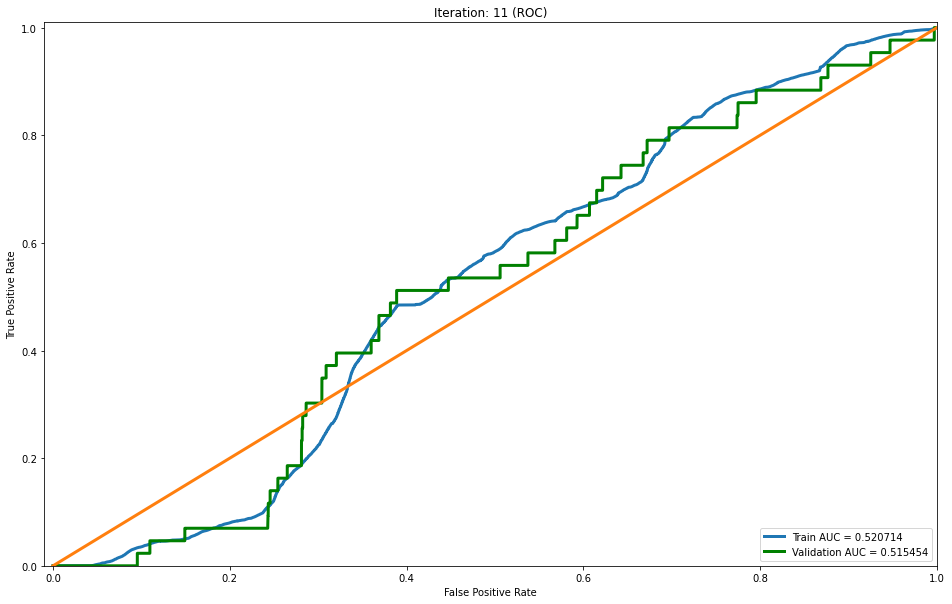

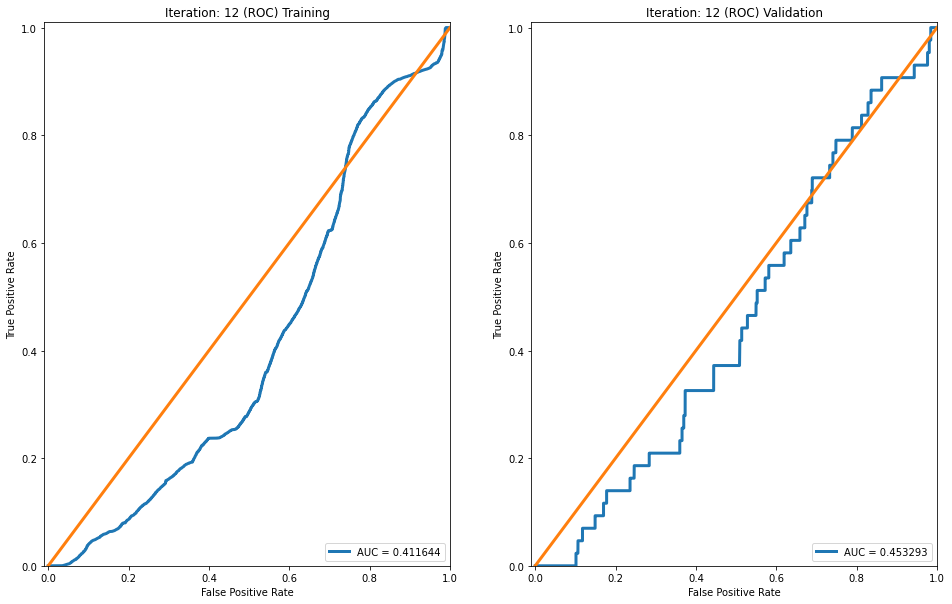

<Figure size 432x288 with 0 Axes>

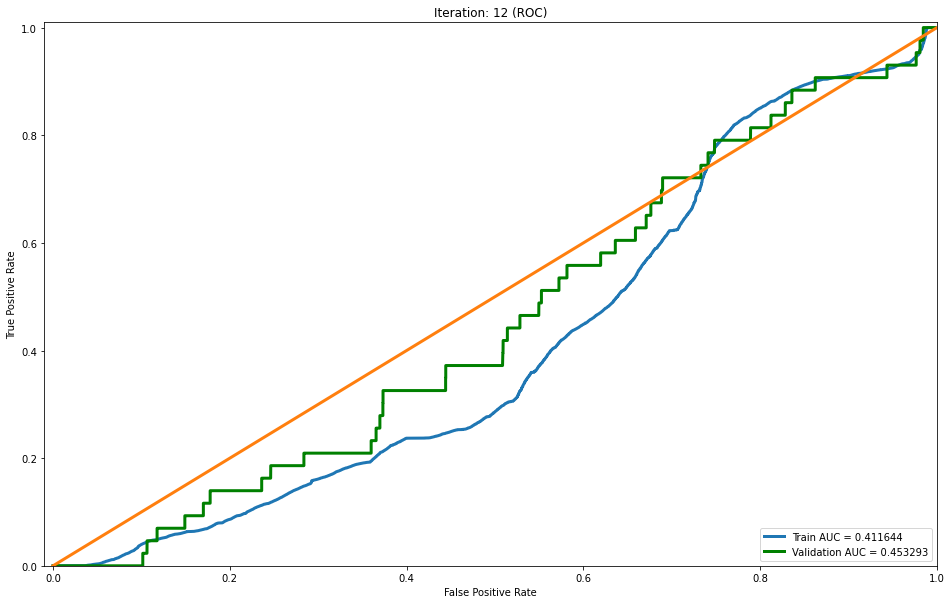

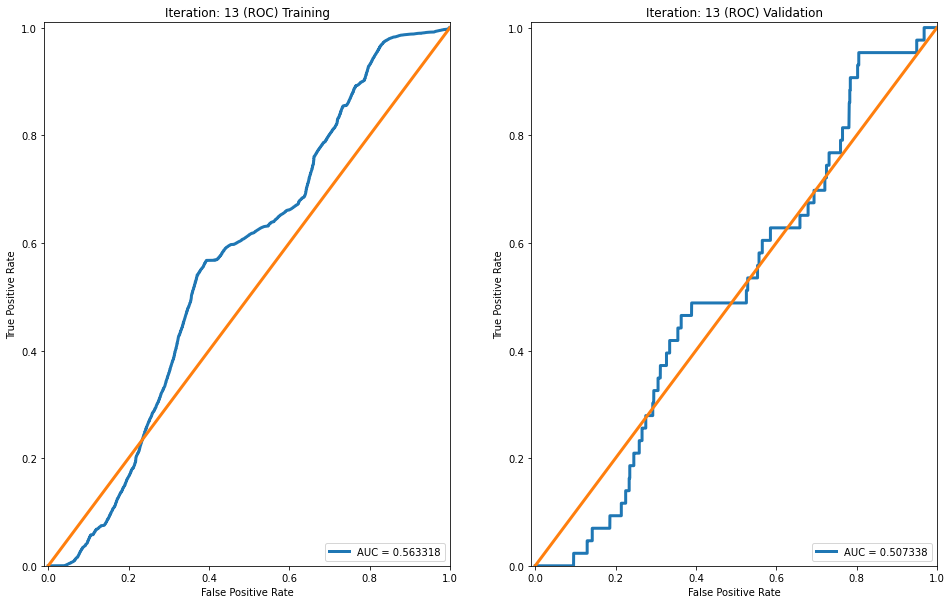

<Figure size 432x288 with 0 Axes>

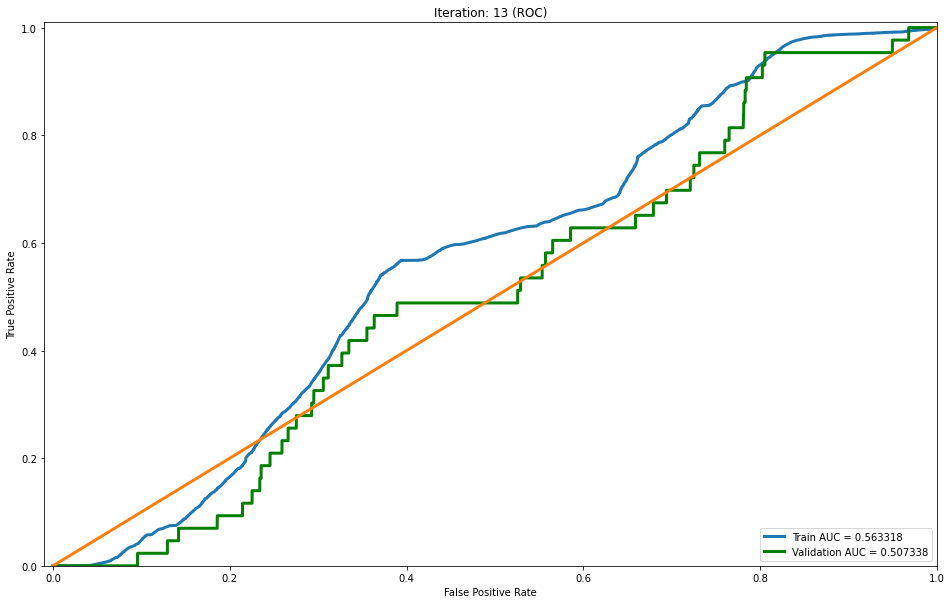

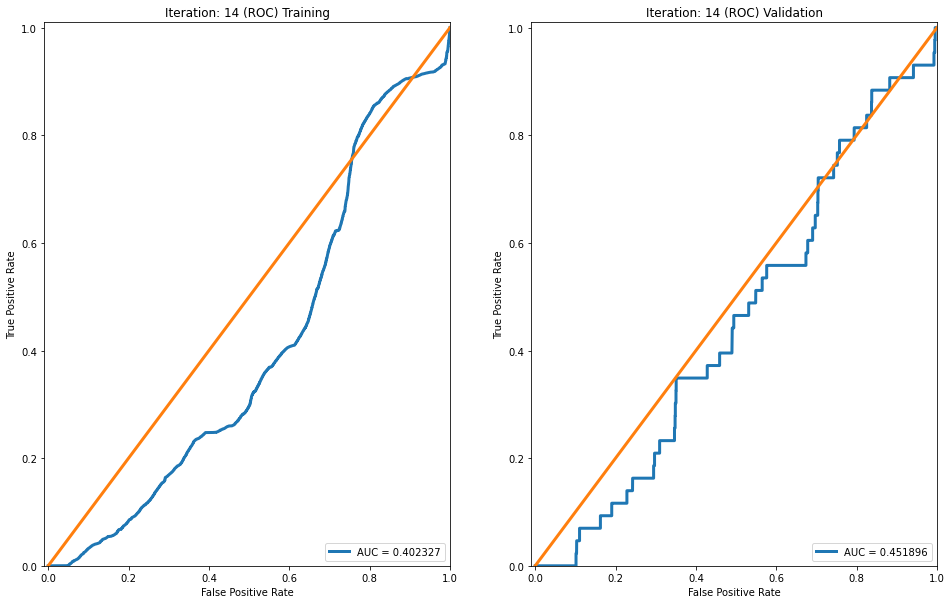

<Figure size 432x288 with 0 Axes>

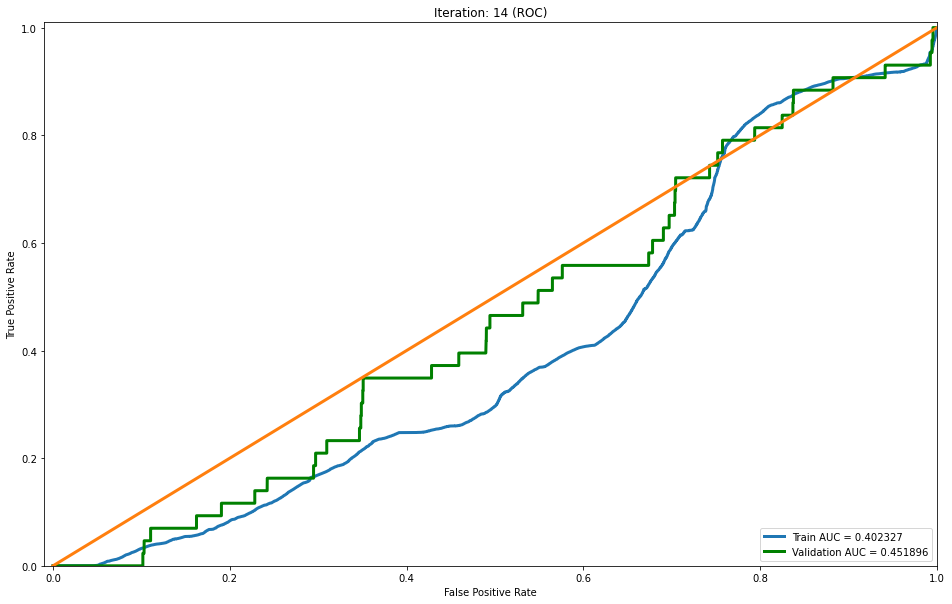

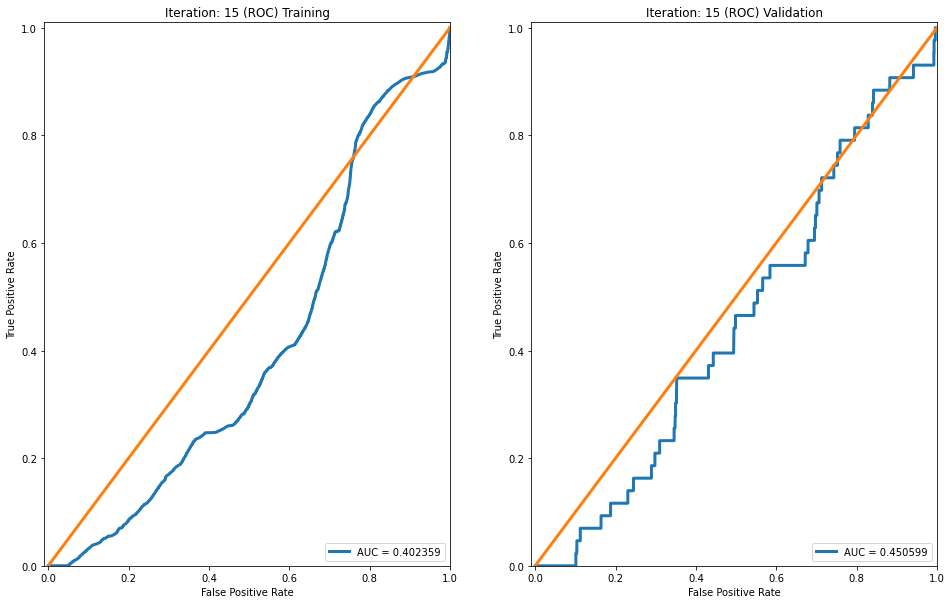

<Figure size 432x288 with 0 Axes>

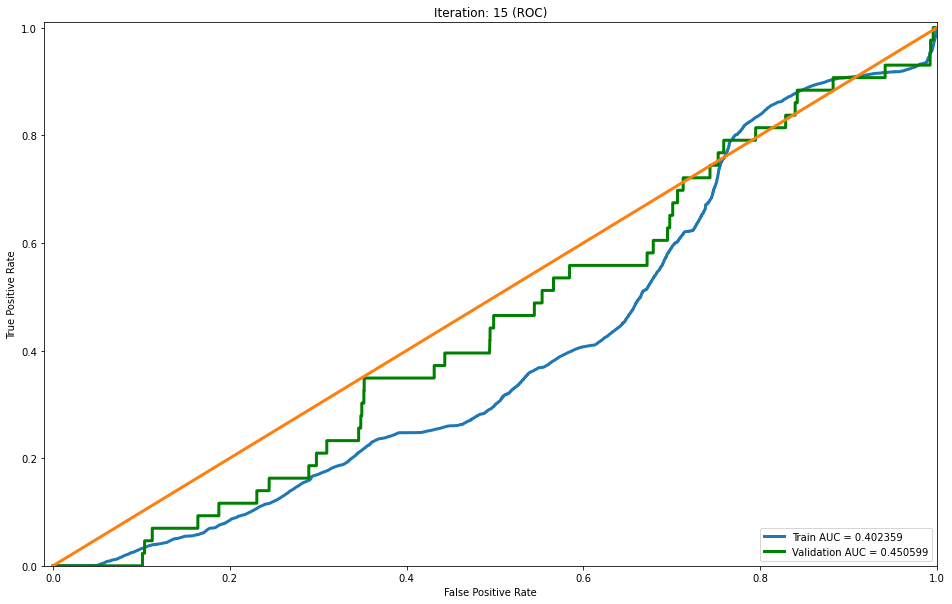

In [33]:
for it in iterations:
    false_pos_rate = eval_train[it]['false_pos_rate']
    true_pos_rate = eval_train[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

    ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %f'% roc_auc)
    ax1.plot([0,1],[0,1], linewidth=3)

    ax1.set_xlim([-0.01, 1])
    ax1.set_ylim([0, 1.01])
    ax1.legend(loc='lower right')
    ax1.set_title('Iteration: '+ str(it) +' (ROC) Training')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')


    test_false_pos_rate = eval_test[it]['false_pos_rate']
    test_true_pos_rate = eval_test[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

    ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f'% test_roc_auc)
    ax2.plot([0,1],[0,1], linewidth=3)

    ax2.set_xlim([-0.01, 1])
    ax2.set_ylim([0, 1.01])
    ax2.legend(loc='lower right')
    ax2.set_title('Iteration: '+ str(it) +' (ROC) Validation')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')

    plt.figure(2)
    false_pos_rate = eval_train[it]['false_pos_rate']
    true_pos_rate = eval_train[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)

    test_false_pos_rate = eval_test[it]['false_pos_rate']
    test_true_pos_rate = eval_test[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

    plt.figure(figsize=(16, 10))
    plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='Train AUC = %f'% roc_auc)
    plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='Validation AUC = %f'% test_roc_auc, color='g')
    plt.plot([0,1],[0,1], linewidth=3)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])

    plt.legend(loc='lower right')
    plt.title('Iteration: '+ str(it) +' (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# # Precision and recall graphs--- delete if not req
# for it in iterations:
#     precision_rt = eval_train[it]['precision_rt']
#     recall_rt = eval_train[it]['recall_rt']
#     threshold_rate = eval_train[it]['threshold_rt']

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#     ax1.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
#     ax1.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
#     #     ax1.set_yscale('log')
#     ax1.legend()
#     ax1.set_title('Iteration: '+ str(it) +' Precision Vs Recall Training')
#     ax1.set_ylabel('Precision/Recall')
#     ax1.set_xlabel('Threshold')


#     precision_rt = eval_test[it]['precision_rt']
#     recall_rt = eval_test[it]['recall_rt']
#     threshold_rate = eval_test[it]['threshold_rt']
#     ax2.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
#     ax2.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
#     ax2.legend()
#     ax2.set_yscale('log')
#     ax2.set_title('Iteration: '+ str(it) +' Precision Vs Recall Validation')
#     ax2.set_ylabel('Precision/Recall')
#     ax2.set_xlabel('Threshold')

Confusion Matrix left

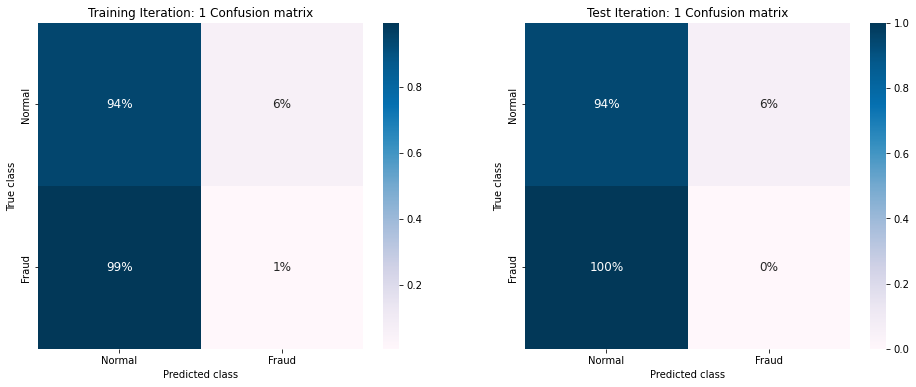

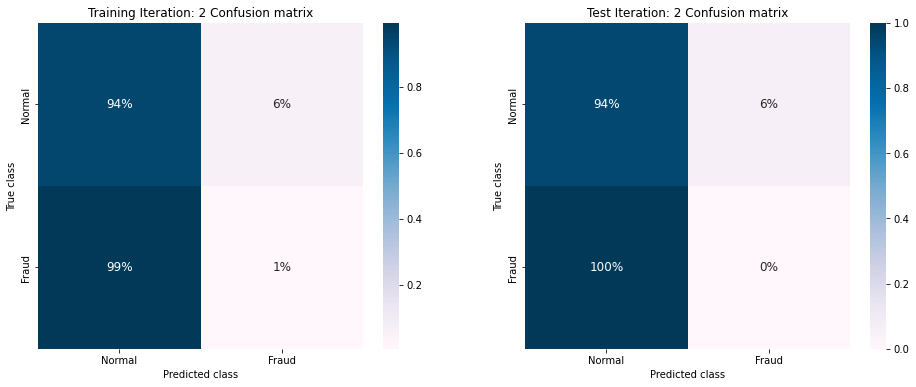

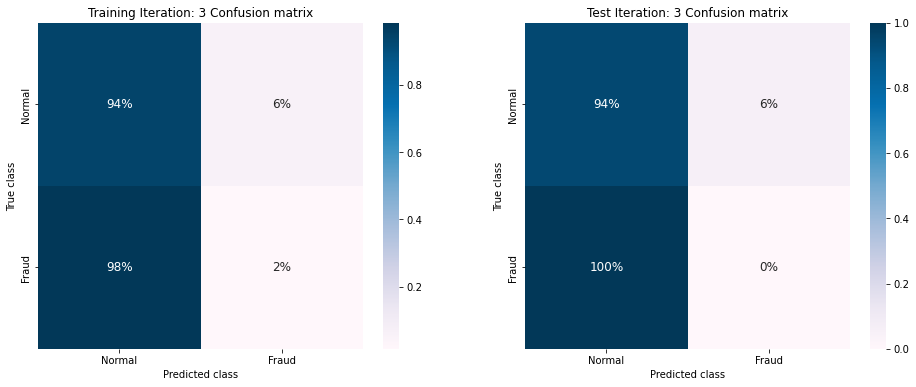

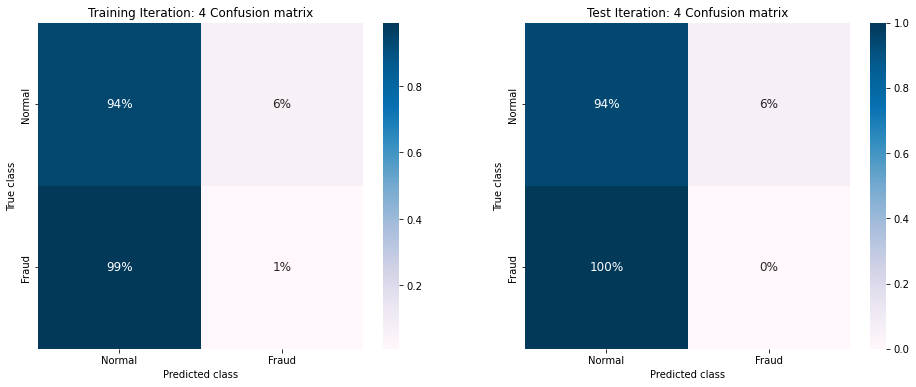

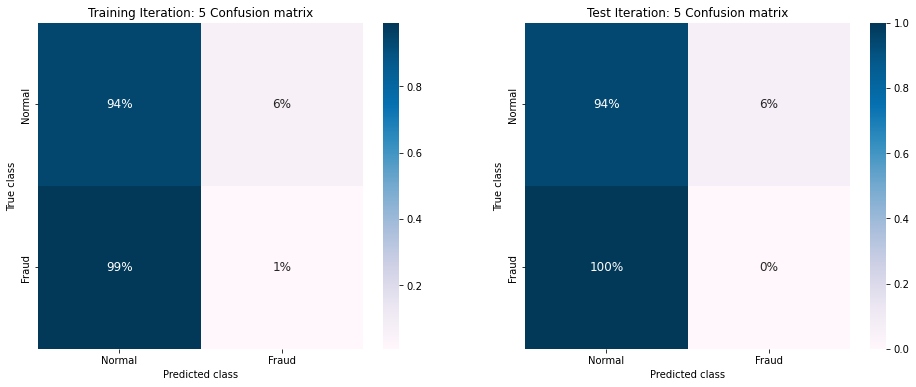

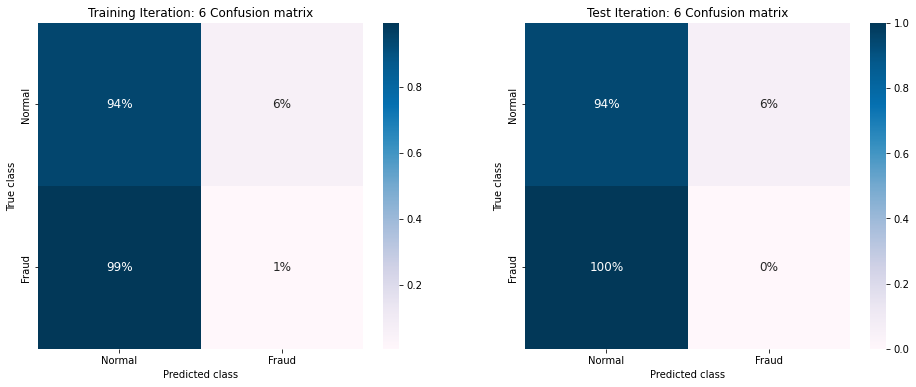

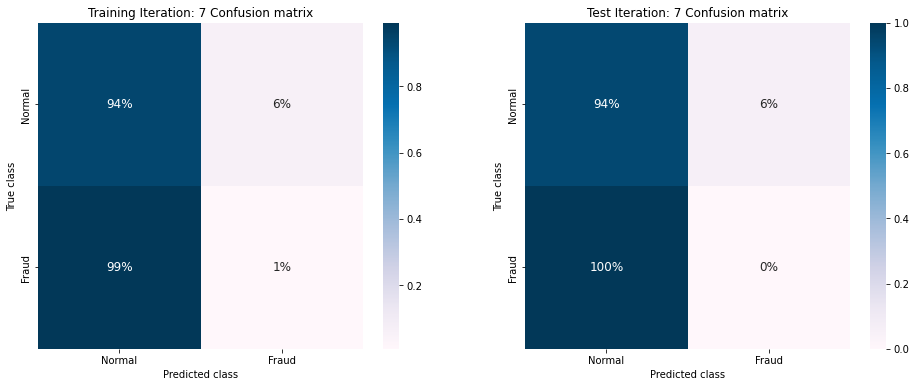

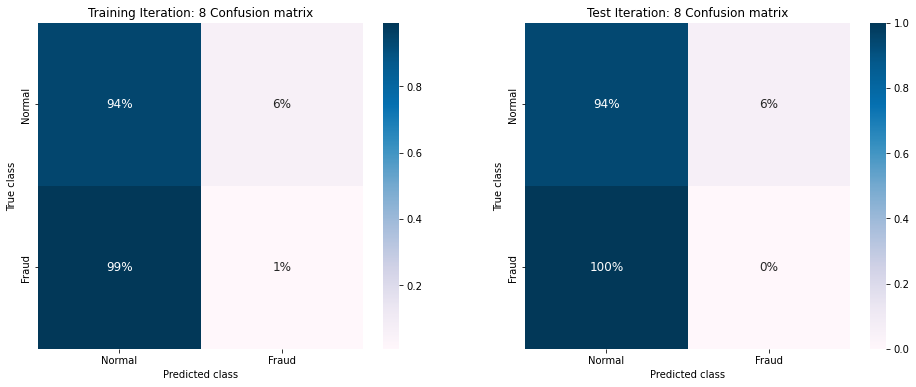

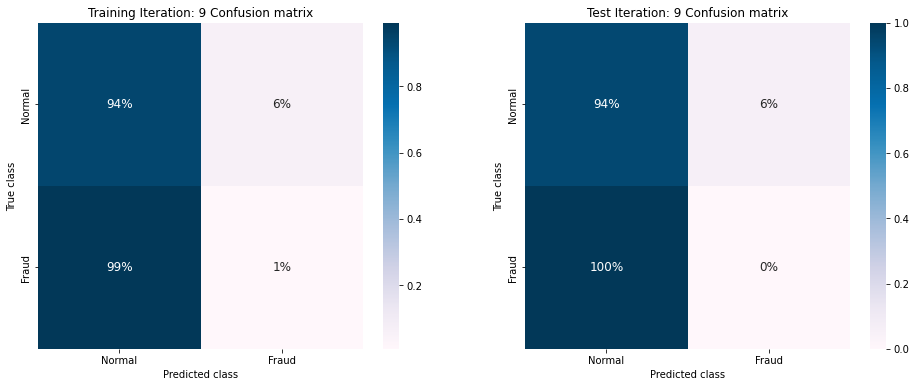

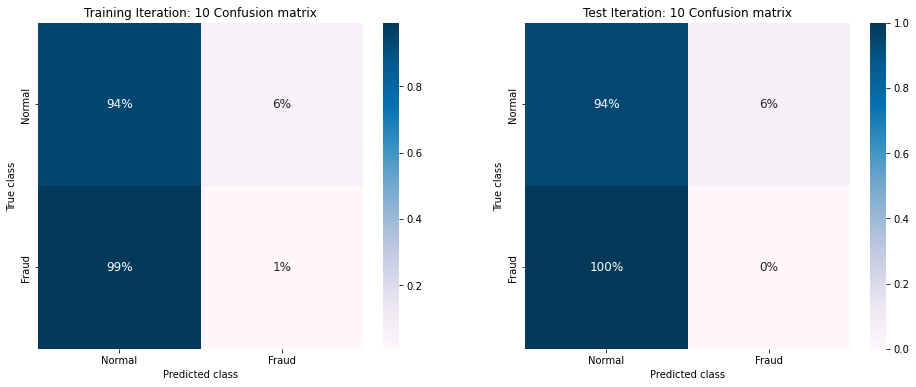

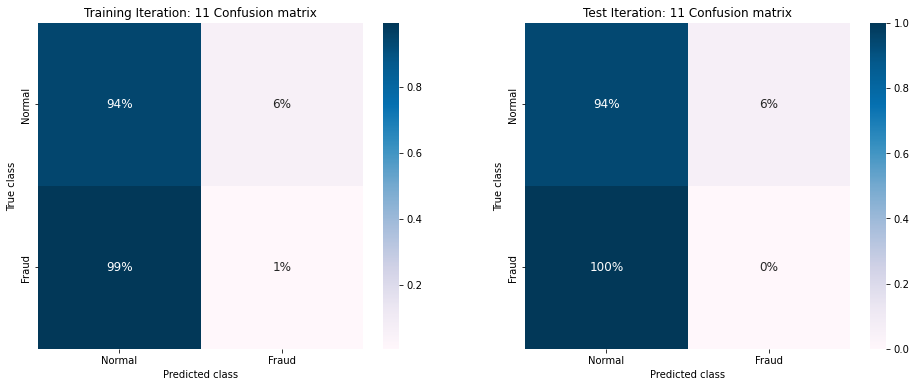

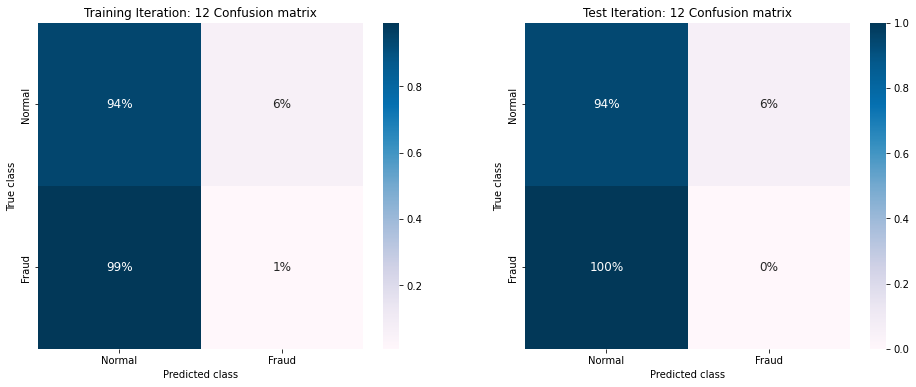

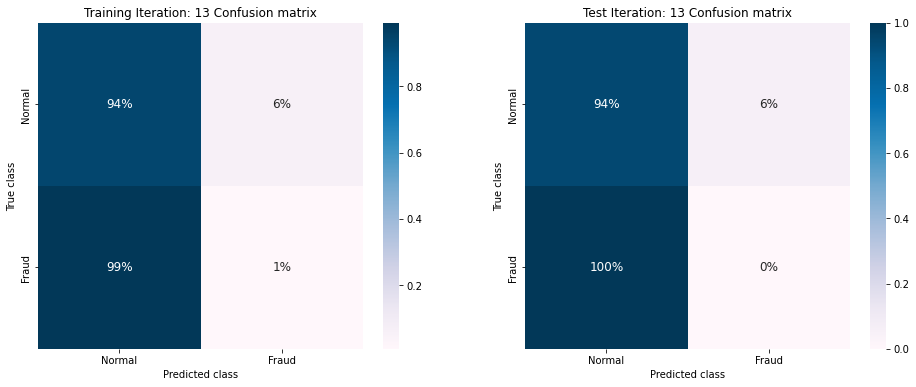

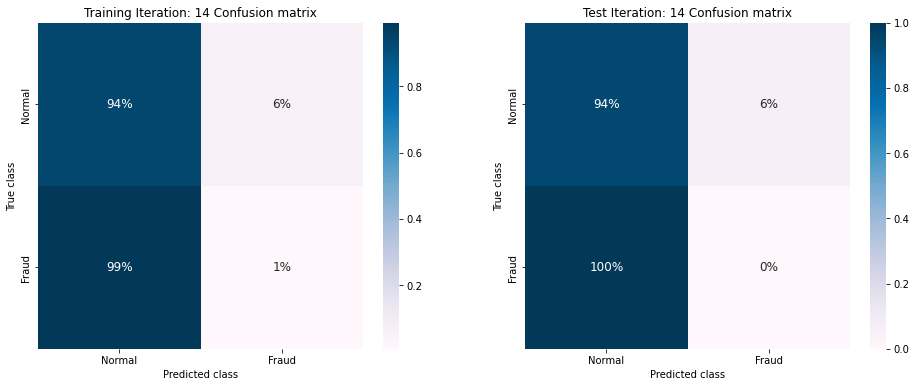

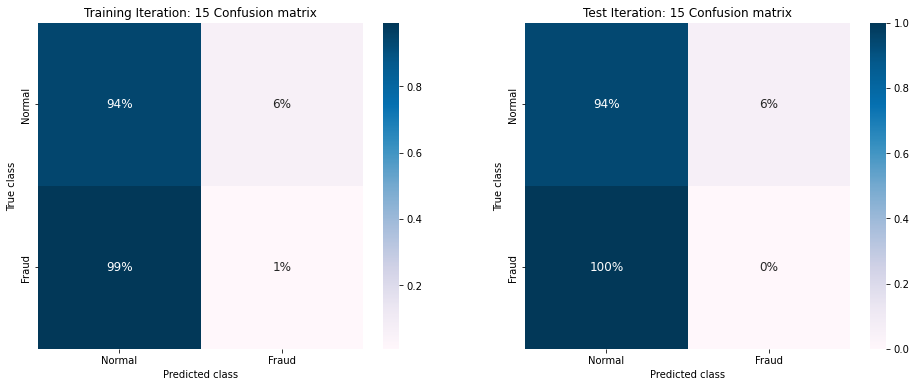

In [34]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
    conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1, cmap="PuBu")
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')

    conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2, cmap="PuBu")
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')


for it in iterations:
    cnf_mtx_train = eval_train[it]['conf_matrix']
    cnf_mtx_test = eval_test[it]['conf_matrix']
    conf_matrix_percent(cnf_mtx_train, cnf_mtx_test, it)

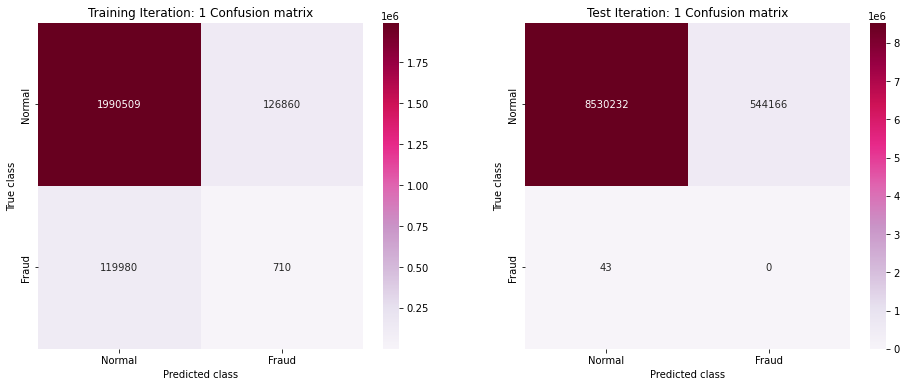

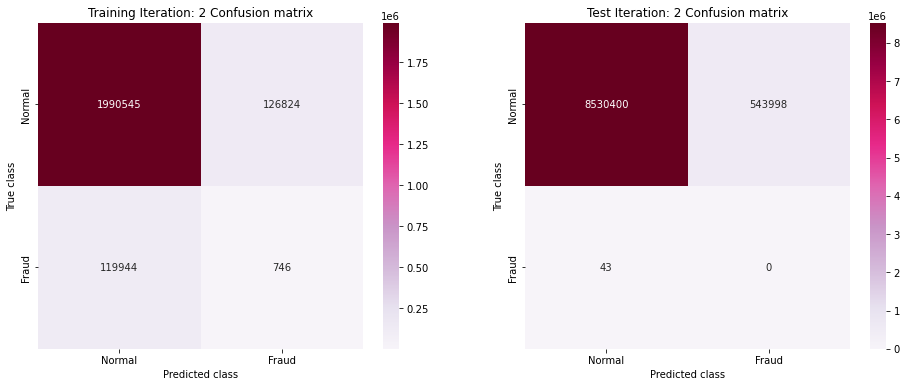

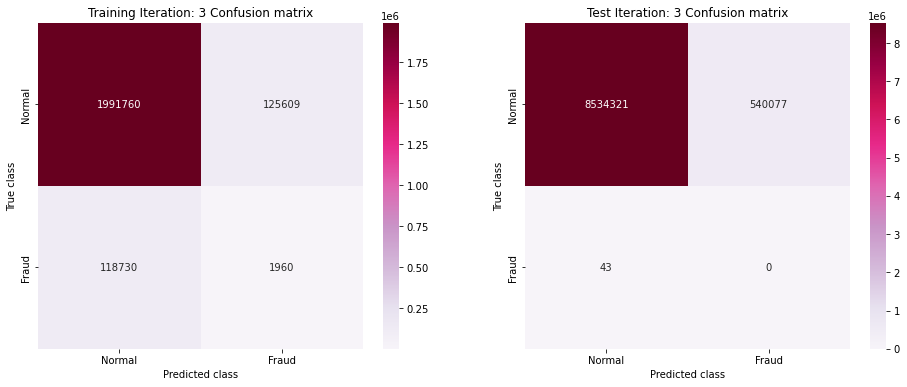

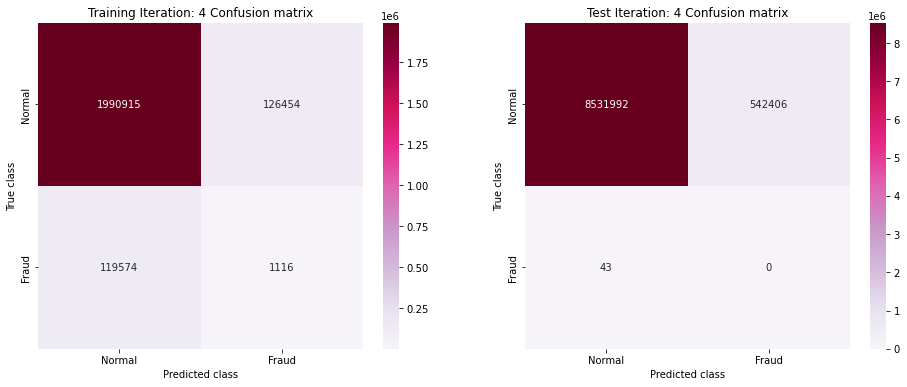

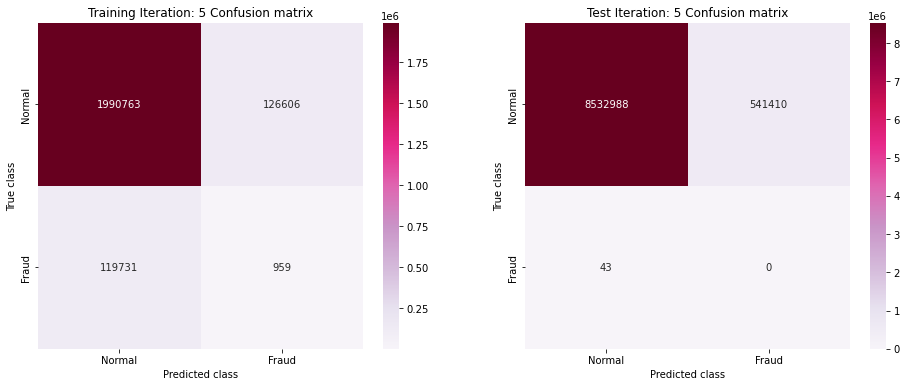

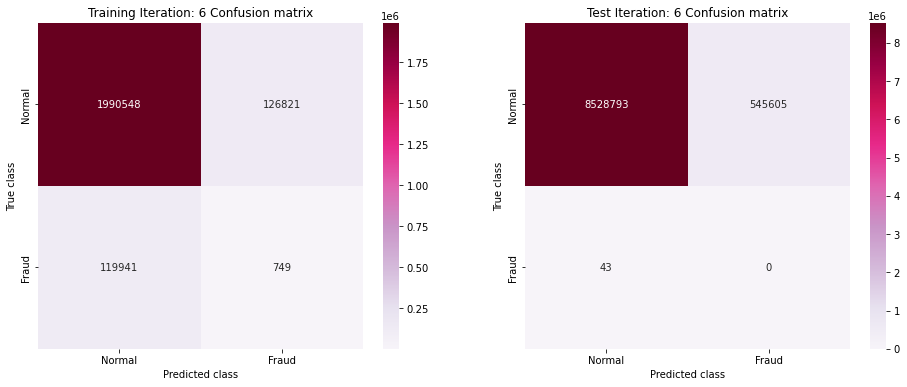

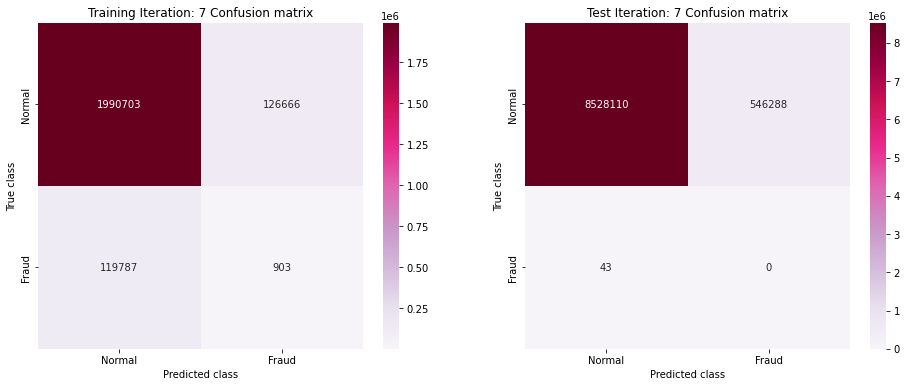

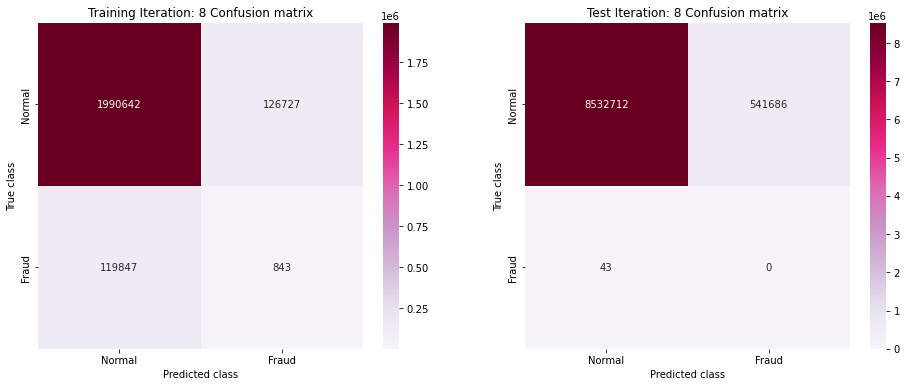

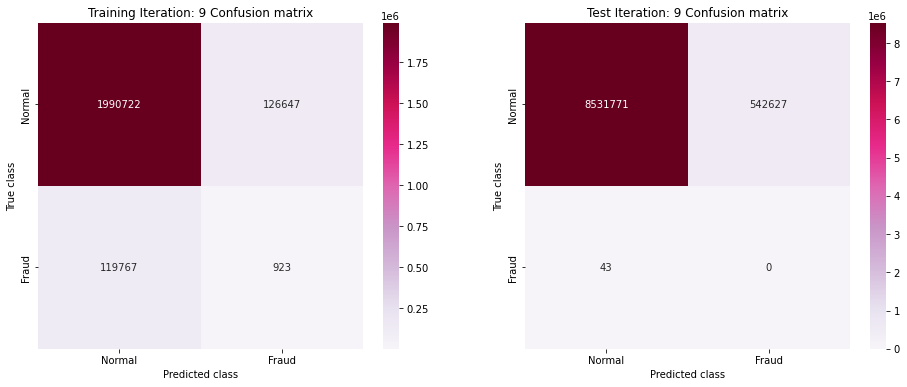

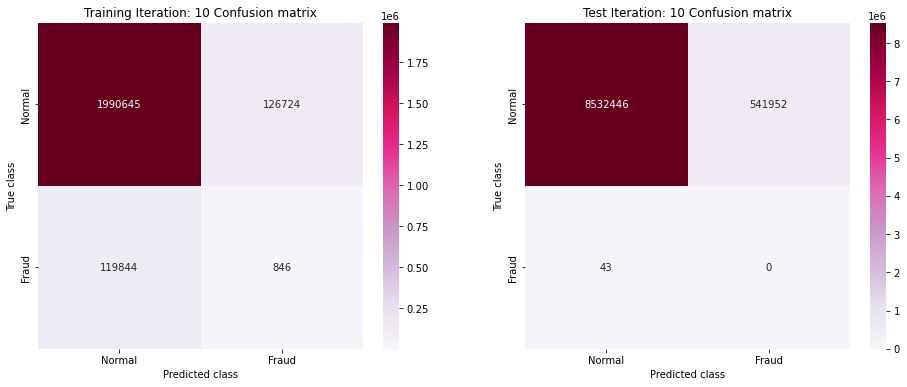

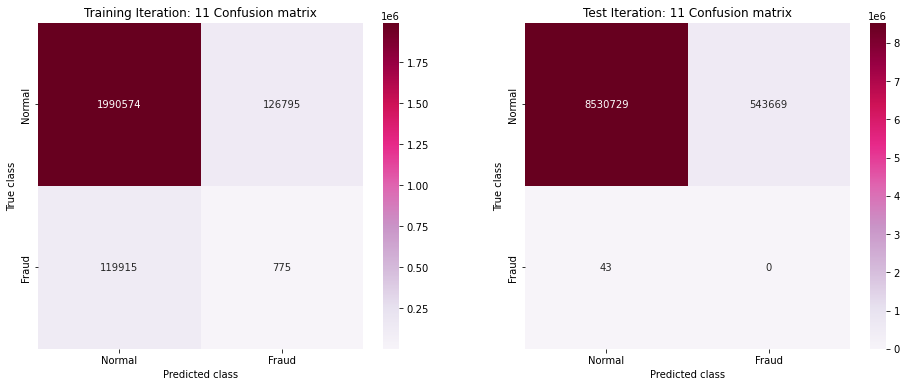

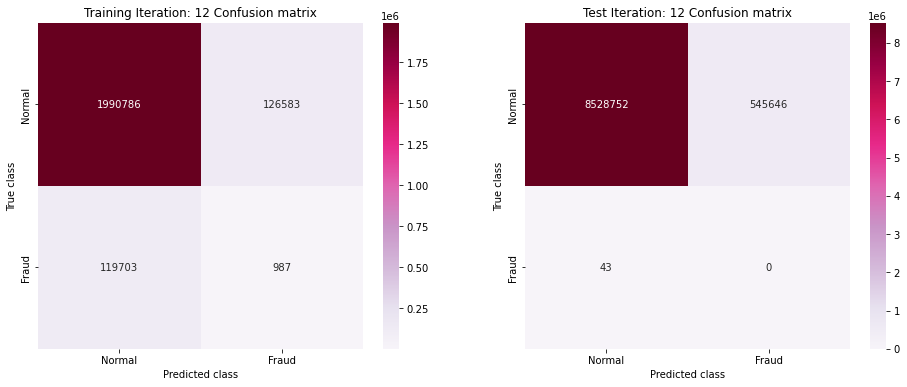

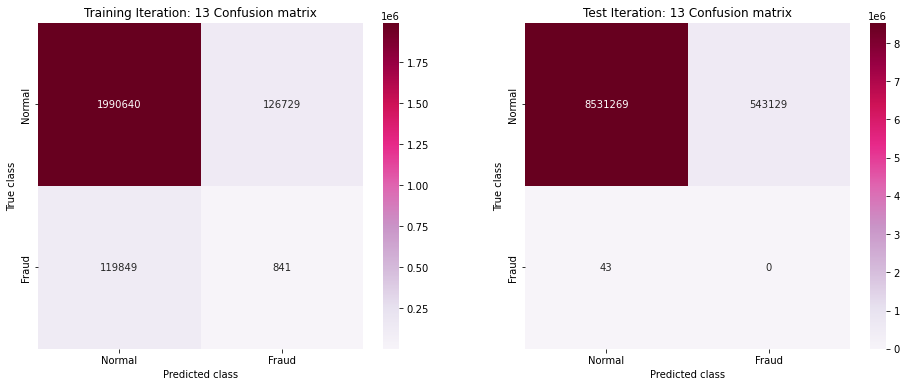

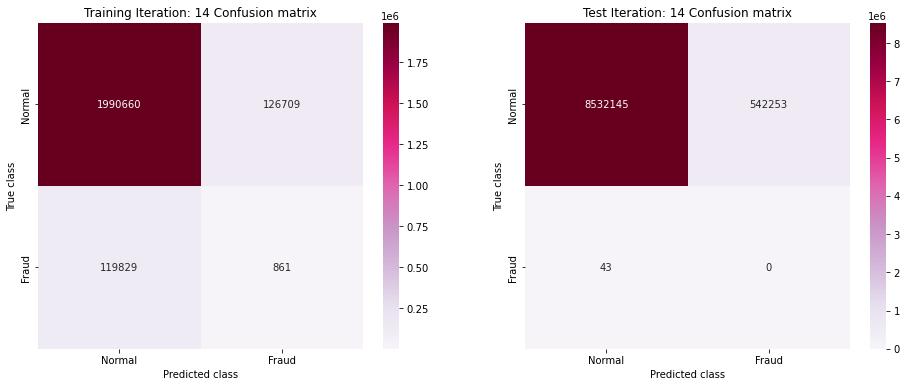

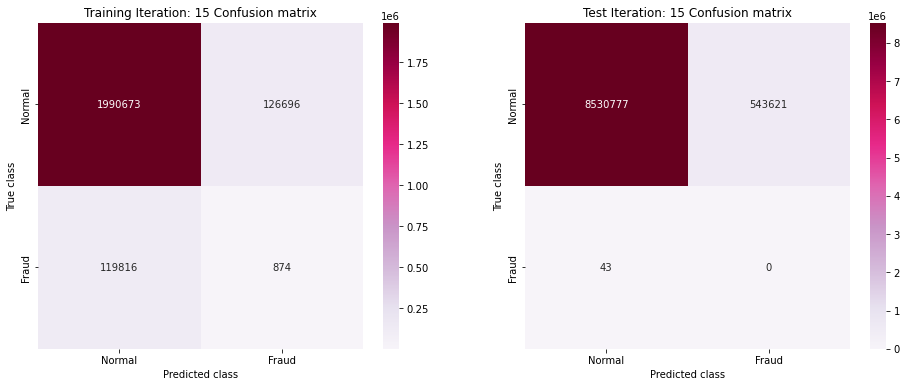

In [35]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]

    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1, cmap="PuRd");
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')


    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2, cmap="PuRd");
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')


for it in iterations:
    cnf_mtx_train = eval_train[it]['conf_matrix']
    cnf_mtx_test = eval_test[it]['conf_matrix']
    conf_matrix_normal(cnf_mtx_train, cnf_mtx_test, it)